# Training for production
copy of BBB_BN_TV_FCN4_SkipC_wDiapCntr_test26_LRx3_x16.ipynb
prod run 1

   Copyright 2015-2023, University of Bern, Laboratory for High Energy Physics and Theodor Kocher Institute, M. Vladymyrov

   Licensed under the Apache License, Version 2.0 (the "License");
   you may not use this file except in compliance with the License.
   You may obtain a copy of the License at

       http://www.apache.org/licenses/LICENSE-2.0

   Unless required by applicable law or agreed to in writing, software
   distributed under the License is distributed on an "AS IS" BASIS,
   WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
   See the License for the specific language governing permissions and
   limitations under the License.


In [21]:
#imports 
import sys
import os
import time
import json

import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipyd
import tensorflow as tf
from tensorflow.python.client import timeline

from utils import net_utils as nu
from utils import imgio as iio
from utils import TrainUtils as tu
from utils import dataset as ds

plt.style.use('ggplot')

In [2]:
devs = [1, 3] # one for training another for preproc (deprecated)
time.sleep(devs[0]*60*3)

## Load dataset

In [3]:
d, v, desc = ds.load_train_val_dataset('data/prepared_datasets/ds_big_all10_ref07/',
                              preproc_devs=('/gpu:1',),
                              minibatch_size=4,
                              queue_len=8,
                              shuffle_output=True,
                              num_proc_threads=8,
                              augment_training=True)

dataset description: "Big dataset (ids=1,2,3,5) labeled by Adrian,Luca,Mykhailo,Sidar
    (04.2021, corrected, aligned data. new format. histogram-normalized input (ref. dataset 7). mean-std norm within 2.5-97.5%).
    Contains labels for cells, diapedesing part, centroids, and exp(-distance/10um) from diapedesing cell part.
    Validation dataset - portion of the dataset, no overlap"


In [4]:
def start_queue(sess):
    pass
    d.start_queues(session=sess)
    #v.start_queues(session=sess)
    
def end_queue(sess):
    pass

# Create Net

In [5]:
MODELNAME = 'BBB_BN_TV_FCNx16_HN_CDC'

In [6]:
def lrelu(x, name=tf.nn.leaky_relu.__name__):
    return tf.nn.leaky_relu(x, alpha=0.05, name=name)

In [7]:
g = d.get_graph()
numFilters = [    64,      128,       128,       128,       256,       512,       256,      256,       512]  # last - num classes
filters = [[7, 7, 1], [3, 3, 3], [3, 3, 1], [3, 3, 1], [3, 3, 1], [3, 3, 3], [3, 3, 1], [3, 3, 1], [3, 3, 1]]
pool =    [[1, 1, 1], [2, 2, 1], [1, 1, 1], [2, 2, 1], [1, 1, 1], [2, 2, 1], [1, 1, 1], [2, 2, 1], [1, 1, 1]]

target = 'nll'

layersP = []

x_before_MP=[]

with g.as_default():
    phase_train = tf.placeholder(tf.bool, name='phase_train')

    with tf.device('/gpu:0'):
        stk_tr, lbl_tr, dia_tr, cnt_tr, dst_tr  = d.get_minibatch_stream()  # try diapedesis
        #stk_vl, lbl_vl, dia_vl  = v.get_minibatch_stream()
        
        stk_vl, lbl_vl, dia_vl, cnt_vl, dst_vl = stk_tr, lbl_tr, dia_tr, cnt_tr, dst_tr
        
        stk0, lbl0, dia0, cnt0, dst0 = tf.cond(phase_train,
                                         lambda : (stk_tr, lbl_tr, dia_tr, cnt_tr, dst_tr),
                                         lambda: (stk_vl, lbl_vl, dia_vl, cnt_vl, dst_vl))

        #stk0 = tf.placeholder(dtype=tf.float32, shape=(None, 5, 256, 256))
        #lbl0 = tf.placeholder(dtype=tf.int32, shape=(None, 5, 256, 256))
        #dia0 = tf.placeholder(dtype=tf.int32, shape=(None, 5, 256, 256))
        
        stk = tf.expand_dims(stk0, 4)
        lbl = lbl0[:,2:3,...]
        dia = dia0[:,2:3,...]
        cnt = cnt0[:,2:3,...]
        dst = dst0[:,2:3,...]
                
        stack = tf.identity(stk, 'stack')
        label = tf.identity(lbl, 'label')
        diapd = tf.identity(dia, 'diapd')
        centr = tf.identity(cnt, 'centr')
        dedst = tf.identity(dst, 'dedst')  # exponential distance from diapedesing cells
        
        x = stack
        for layerIdx, nFilt in enumerate(numFilters):
            k = filters[layerIdx]
            p = pool[layerIdx]

            x, *_ = nu.conv_3D(x,
                               nFilt,
                               name='L%d' % layerIdx,
                               k_w=k[0],
                               k_h=k[1],
                               k_d=k[2], 
                               batch_norm_train_phase=None if layerIdx==0 else phase_train,
                               dropout_keep_prob=None if layerIdx==0 else 0.8,
                               padding='SAME',
                               activation=lrelu, initializer=tf.initializers.he_uniform
                              )
            
            if k[2]>1:
                curr_d = tf.shape(x)[1]
                new_d = curr_d - k[2] + 1
                d_ofs = (k[2]-1) // 2
                
                #x = tf.slice(x, begin=(0, d_ofs, 0, 0, 0),
                #             size=(-1, new_d ,-1,-1,-1),
                #             name='SliceX%d' % layerIdx)
                x = x[:, d_ofs: d_ofs+new_d]
            
            if np.max(p) > 1:
                curr_d = tf.shape(x)[1]
                new_d = 1
                d_ofs = (curr_d-new_d) // 2

                x_slice = tf.slice(x, begin=(0, d_ofs, 0, 0, 0),
                                   size=(-1, new_d ,-1,-1,-1),
                                   name='Slice%d' % layerIdx) #x_slice = x[:, 2:3, ...]
                x_before_MP.append(x_slice)
                x = nu.max_pool_3d(
                    x,
                    name='MP%d' % layerIdx,
                    k_w=p[0],
                    k_h=p[1],
                    k_d=p[2],
                    s_x=p[0],
                    s_y=p[1],
                    s_z=p[2])
            layersP.append(x)
            
        curr_d = tf.shape(x)[1]
        new_d = 1
        d_ofs = (curr_d-new_d) // 2
        #x = tf.slice(x, begin=(0, d_ofs, 0, 0, 0),
        #             size=(-1, new_d ,-1,-1,-1),
        #             name='Slice%d' % layerIdx) #x = x[:, 2:3, ...]
        x = x[:, d_ofs: d_ofs+new_d]

        layerIdx = len(numFilters)
        
        x, *_ = nu.upscale_3D(x, 256, 2, 2, 1, padding='SAME', name='L%d' % layerIdx,
                              batch_norm_train_phase=phase_train,
                              activation=lrelu,
                             )
        layersP.append(x)
        layerIdx += 1

        x = tf.concat((x, x_before_MP[3]), axis=-1, name='concat%d' % layerIdx)
        layersP.append(x)
        layerIdx += 1
        x, *_ = nu.conv_3D(x, 256, k_d=1, 
                           batch_norm_train_phase=phase_train,           
                           dropout_keep_prob=0.8, padding='SAME', name='L%d' % layerIdx,
                           activation=lrelu, initializer=tf.initializers.he_uniform
                          )
        layersP.append(x)
        layerIdx += 1
        
        
        x, *_ = nu.upscale_3D(x, 128, 2, 2, 1, padding='SAME', name='L%d' % layerIdx,
                              batch_norm_train_phase=phase_train,
                              activation=lrelu
                             )
        layersP.append(x)
        layerIdx += 1

        x = tf.concat((x, x_before_MP[2]), axis=-1, name='concat%d' % layerIdx)
        layersP.append(x)
        layerIdx += 1

        x, *_ = nu.conv_3D(x, 128, k_d=1, 
                           batch_norm_train_phase=phase_train,
                           dropout_keep_prob=0.8, padding='SAME', name='L%d' % layerIdx,
                           activation=lrelu, initializer=tf.initializers.he_uniform
                          )
        layersP.append(x)
        layerIdx += 1
        x, *_ = nu.conv_3D(x, 128, k_d=1, 
                           batch_norm_train_phase=phase_train,
                           dropout_keep_prob=0.8, padding='SAME', name='L%d' % layerIdx,
                           activation=lrelu, initializer=tf.initializers.he_uniform
                          )
        layersP.append(x)
        layerIdx += 1
        
        
        x, *_ = nu.upscale_3D(x, 128, 2, 2, 1, padding='SAME', name='L%d' % layerIdx,
                              batch_norm_train_phase=phase_train,
                              activation=lrelu
                             )
        layersP.append(x)
        layerIdx += 1

        x = tf.concat((x, x_before_MP[1]), axis=-1, name='concat%d' % layerIdx)
        layersP.append(x)
        layerIdx += 1

        x, *_ = nu.conv_3D(x, 128, k_d=1, 
                           batch_norm_train_phase=phase_train,
                           dropout_keep_prob=0.8, padding='SAME', name='L%d' % layerIdx,
                           activation=lrelu, initializer=tf.initializers.he_uniform
                          )
        layersP.append(x)
        layerIdx += 1
        x, *_ = nu.conv_3D(x, 128, k_d=1, 
                           batch_norm_train_phase=phase_train,
                           dropout_keep_prob=0.8, padding='SAME', name='L%d' % layerIdx,
                           activation=lrelu, initializer=tf.initializers.he_uniform
                          )
        layersP.append(x)
        layerIdx += 1
        
        x, *_ = nu.upscale_3D(x, 64, 2, 2, 1, padding='SAME', name='L%d' % layerIdx,
                              batch_norm_train_phase=phase_train,
                              activation=lrelu
                             )
        layersP.append(x)
        layerIdx += 1

        x = tf.concat((x, x_before_MP[0]), axis=-1, name='concat%d' % layerIdx)
        layersP.append(x)
        layerIdx += 1

        x, *_ = nu.conv_3D(x, 64, k_d=1, 
                           batch_norm_train_phase=phase_train,
                           dropout_keep_prob=0.8, padding='SAME', name='L%d' % layerIdx,
                           activation=lrelu, initializer=tf.initializers.he_uniform
                          )
        layersP.append(x)
        layerIdx += 1
        
        x, *_ = nu.conv_3D(x, 64, k_d=1, 
                           batch_norm_train_phase=phase_train,
                           dropout_keep_prob=0.8, padding='SAME', name='L%d' % layerIdx,
                           activation=lrelu, initializer=tf.initializers.he_uniform
                          )
        layersP.append(x)
        layerIdx += 1
        
        rich_layer = x
        x, *_ = nu.conv_3D(x, 2, name='L%d' % layerIdx,
                           k_w=1, k_h=1, k_d=1,
                           activation=None,
                           padding='SAME',
                           initializer=tf.initializers.he_uniform
                          )
        layersP.append(x)
        layerIdx += 1

        L = x

        logits_cd = x#[..., :2]
        Y = nu.sigmoid(logits_cd, 'Classifier')
        
        x, *_ = nu.conv_3D(rich_layer, n_output_ch=16, k_d=1, name='L%d' % layerIdx,
                           batch_norm_train_phase=phase_train,
                           dropout_keep_prob=0.9, padding='SAME',
                           activation=lrelu, initializer=tf.initializers.he_uniform
                          )
        layersP.append(x)
        layerIdx += 1
        x, *_ = nu.conv_3D(x, n_output_ch=1, k_d=1, name='L%d' % layerIdx,
                           activation=None, padding='SAME',
                           initializer=tf.initializers.he_uniform
                          )
        layersP.append(x)
        layerIdx += 1
        
        x = 1.1 * tf.sigmoid(x) - 0.05

        C = x[..., 0]
        
        output = tf.concat([Y, x], axis=-1, name='ModelOutput')
    
        draw_states = [stack[0, 2, :, :, 0],
                       Y[0, 0, ..., 0],
                       label[0, 0, :, :],
                       Y[0, 0, ..., 1],
                       diapd[0, 0, :, :],
                       C[0, 0],
                       centr[0, 0, :, :],
                      ]
        
    with tf.device('/cpu:0'):
        with tf.variable_scope('sample'):
            sum_stk_dst = tf.summary.image('stack_smpl', tf.reshape(stack[0, 2,...], [-1, 256, 256, 1]),
                                             2, collections=['sample'])
            sum_lblc_dst = tf.summary.image('labelc_smpl', 255*tf.reshape(tf.cast(label[0], tf.uint8),
                                                                         [-1, 256, 256, 1]),
                                             2, collections=['sample'])
            sum_lbld_dst = tf.summary.image('labeld_smpl', 255*tf.reshape(tf.cast(diapd[0], tf.uint8),
                                                                         [-1, 256, 256, 1]),
                                             2, collections=['sample'])
            sum_lblC_dst = tf.summary.image('labelC_smpl', tf.reshape(centr[0], [-1, 256, 256, 1]),
                                             2, collections=['sample'])


            sum_yc = tf.summary.image('predc_smpl', tf.reshape(Y[0,...,0], [-1, 256, 256, 1]),
                                      2, collections=['sample'])
            sum_yd = tf.summary.image('predd_smpl', tf.reshape(Y[0,...,1], [-1, 256, 256, 1]),
                                      2, collections=['sample'])
            sum_yC = tf.summary.image('predC_smpl', tf.reshape(C[0], [-1, 256, 256, 1]),
                                      2, collections=['sample'])
            

In [7]:
layersP

[<tf.Tensor 'L0/lrelu:0' shape=(?, 5, 256, 256, 64) dtype=float32>,
 <tf.Tensor 'MP1/MP:0' shape=(?, ?, 128, 128, 128) dtype=float32>,
 <tf.Tensor 'L2/lrelu:0' shape=(?, ?, 128, 128, 128) dtype=float32>,
 <tf.Tensor 'MP3/MP:0' shape=(?, ?, 64, 64, 128) dtype=float32>,
 <tf.Tensor 'L4/lrelu:0' shape=(?, ?, 64, 64, 256) dtype=float32>,
 <tf.Tensor 'MP5/MP:0' shape=(?, ?, 32, 32, 512) dtype=float32>,
 <tf.Tensor 'L6/lrelu:0' shape=(?, ?, 32, 32, 256) dtype=float32>,
 <tf.Tensor 'MP7/MP:0' shape=(?, ?, 16, 16, 256) dtype=float32>,
 <tf.Tensor 'L8/lrelu:0' shape=(?, ?, 16, 16, 512) dtype=float32>,
 <tf.Tensor 'L9/lrelu:0' shape=(?, ?, ?, ?, 256) dtype=float32>,
 <tf.Tensor 'concat10:0' shape=(?, 1, 32, 32, 512) dtype=float32>,
 <tf.Tensor 'L11/lrelu:0' shape=(?, 1, 32, 32, 256) dtype=float32>,
 <tf.Tensor 'L12/lrelu:0' shape=(?, ?, ?, ?, 128) dtype=float32>,
 <tf.Tensor 'concat13:0' shape=(?, 1, 64, 64, 640) dtype=float32>,
 <tf.Tensor 'L14/lrelu:0' shape=(?, 1, 64, 64, 128) dtype=float32>,

In [8]:
with g.as_default():
    with tf.device('/gpu:0'):
        labels_cd = tf.stack((label, diapd), axis=-1)
        labels_cd = tf.cast(labels_cd, dtype=tf.float32, name='labelsCDfloat32')

        reshaped_logits = tf.reshape(logits_cd, [-1])
        reshaped_labels = tf.reshape(labels_cd, [-1])
        
        reshaped_centr_prd = tf.reshape(C, [-1])
        reshaped_centr_lbl = tf.reshape(centr, [-1])
        
        loss_px = tf.nn.sigmoid_cross_entropy_with_logits(
            name='XentropyLoss',
            logits=reshaped_logits,
            labels=reshaped_labels)
        
        w_at_diap = 3
        weight_c = dedst*(w_at_diap-1) + 1
        weight_d = dedst*0 + 1
        weight_cd = tf.stack((weight_c, weight_d), axis=-1)
        reshaped_weight_cd = tf.reshape(weight_cd, [-1])
        
        loss_centr = reshaped_centr_prd - reshaped_centr_lbl
        loss_centr = tf.abs(loss_centr)

        loss_px_w = loss_px * reshaped_weight_cd
        loss_px_m = tf.reduce_mean(loss_px_w)
        loss_cnt_m = tf.reduce_mean(loss_centr)
        
        loss = loss_px_m + 5 * loss_cnt_m

        lr = nu.LearningRate(value=0.001)
        lrv = lr.get_var()

        opt = tf.train.AdamOptimizer(
            name='AdamOnXent', learning_rate=lrv, beta1=0.99).minimize(loss)

In [9]:
nu.get_num_trainable_params(g)

11669043

# Train Net

In [9]:
tr_cfg_dict = {
    'graph':g,
    'feed_dict_tensors': [stk0, lbl0, dia0, cnt0, dst0],
    'opt': opt,
    'loss': loss,
    'lr': lr,
    'mb_gen_tra': d.get_minibatch,
    'mb_gen_val': v.get_minibatch,
    'init': start_queue,
    'fin': end_queue,
    'feed_dict_tra': False,
    'feed_dict_val': True,
    'train_phase_ph': phase_train,
    'num_val_minibatches': v.batch_size // v.minibatch_size,
    'draw_states': draw_states,
    'draw_states_ttl': ['raw', 'inferred cells', 'label cells', 'inferred diap', 'label diap', 'inferred cntr', 'label cntr']
}

In [10]:
t = tu.Trainer(tr_cfg_dict, model_name=MODELNAME, models_save_dir='BBB', dev_id=None, dev_ids=devs)

checkpoints will be saved to: BBB/model_BBB_BN_TV_FCNx16_HN_CDC_2021.07.06_16-25
Setting lr=0.000375
time per it: 26.879606
feed dict for validation


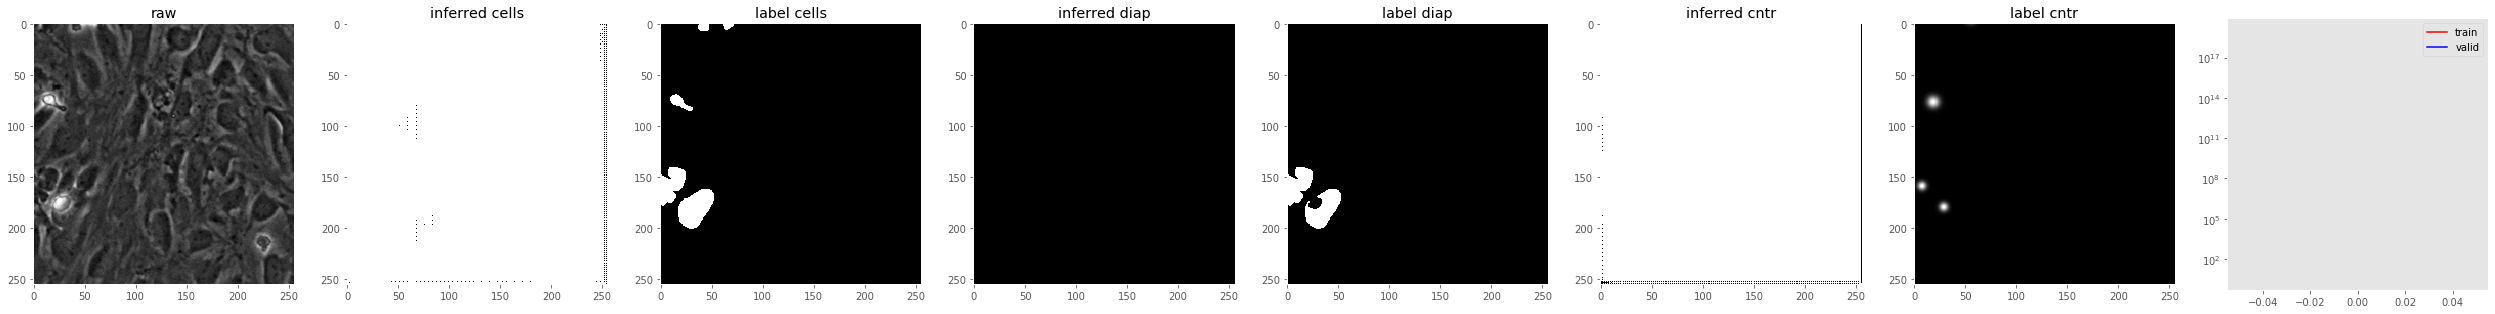

time per it: 13.305458


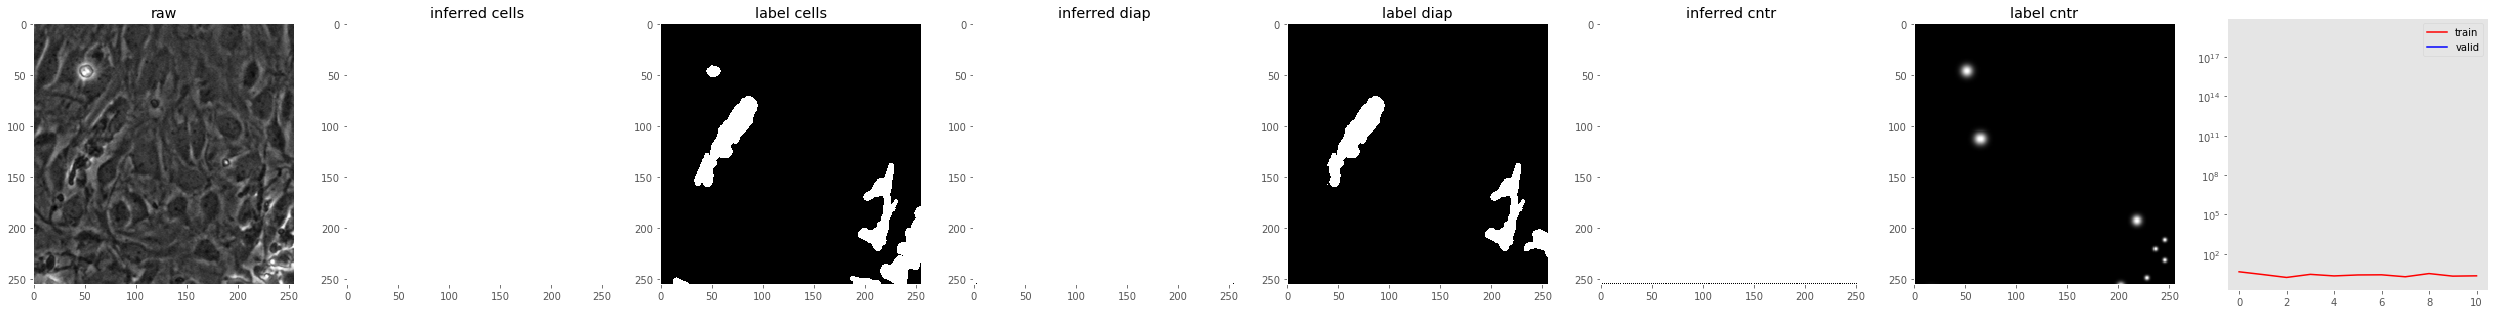

time per it: 2.973914


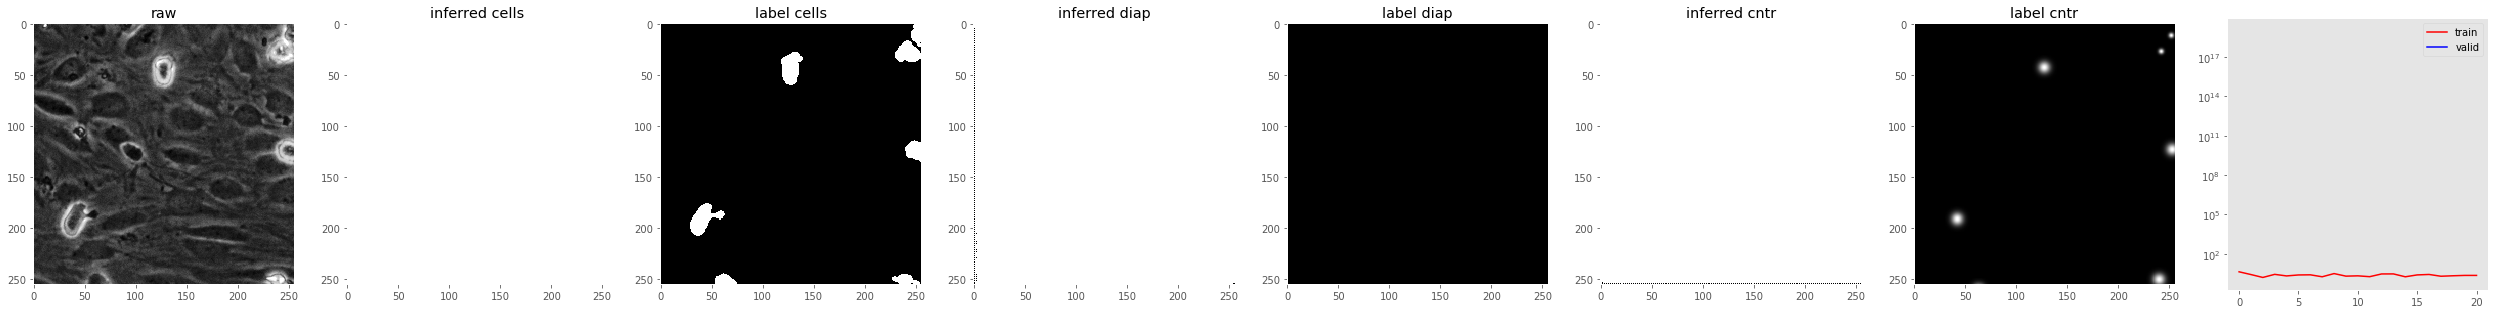

time per it: 2.985232


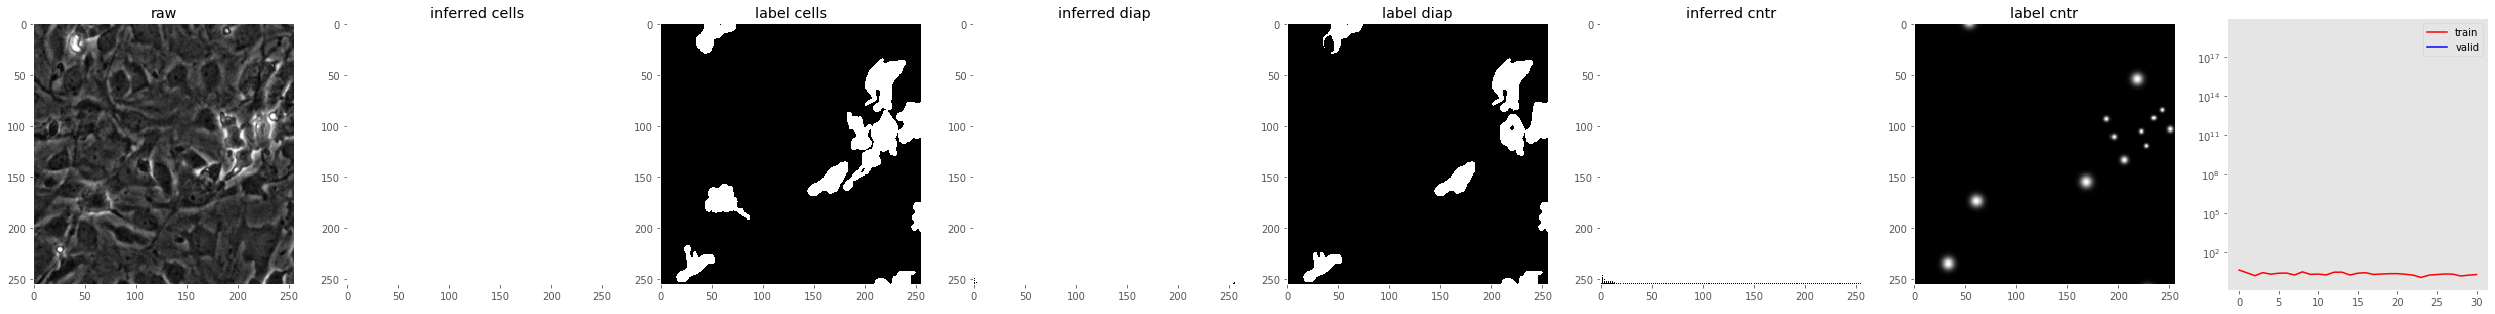

time per it: 2.996666


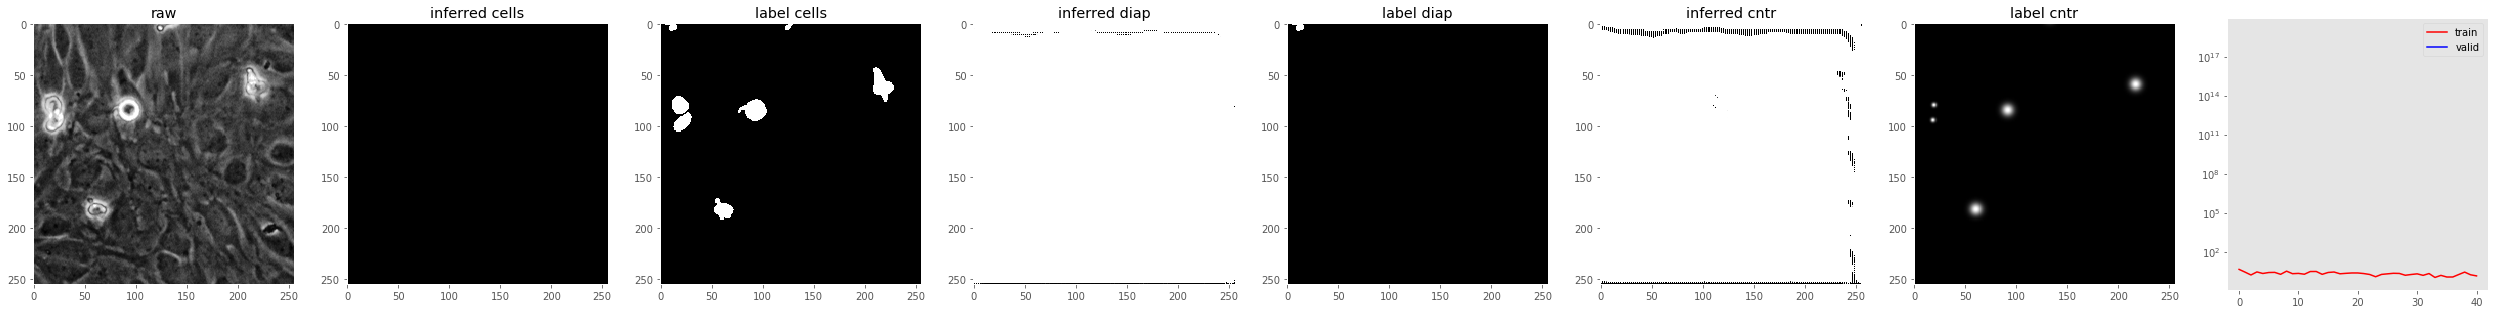

time per it: 3.057898


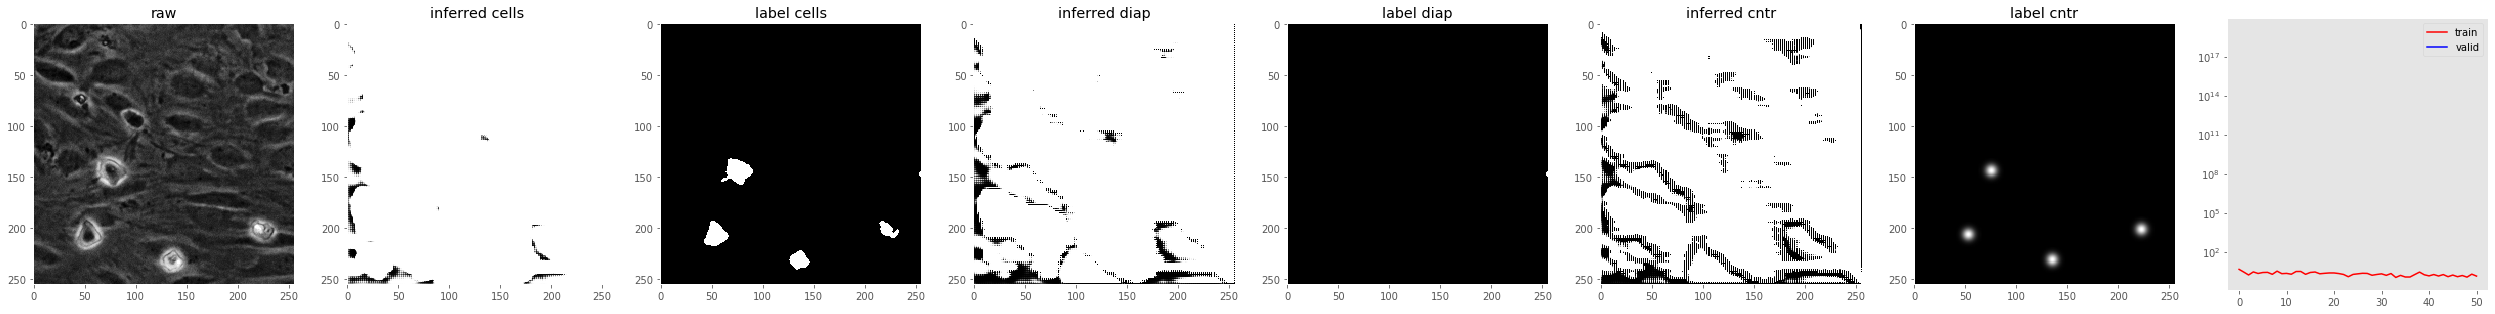

time per it: 3.024115


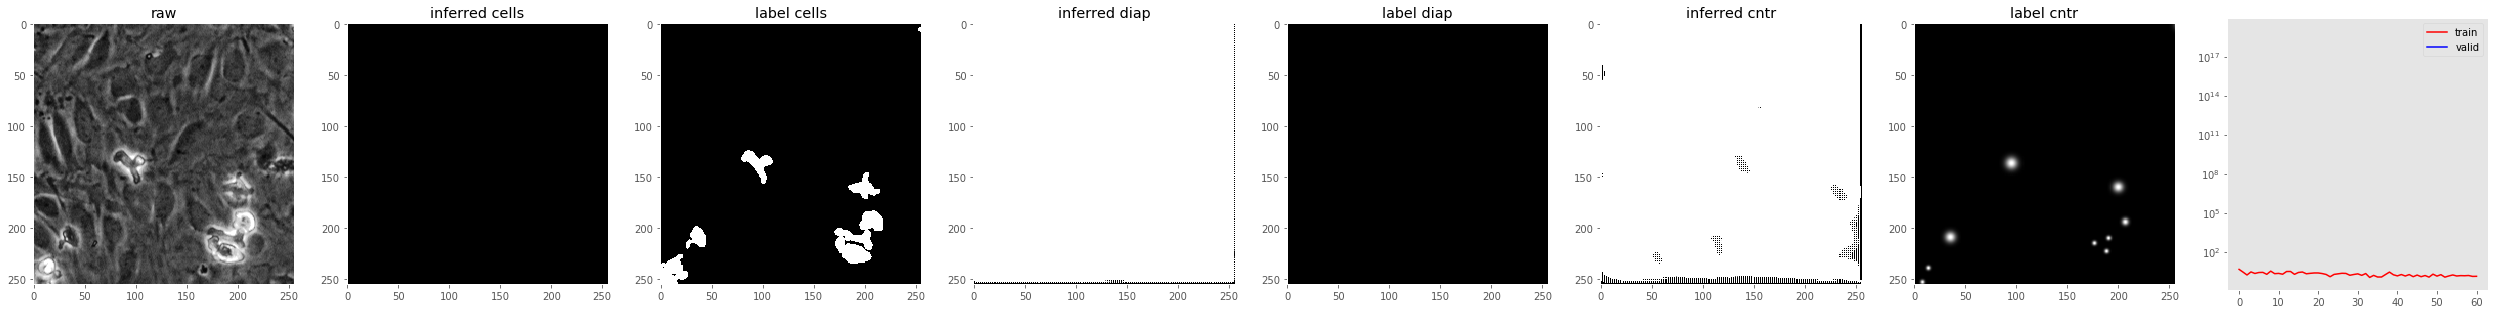

time per it: 3.033540


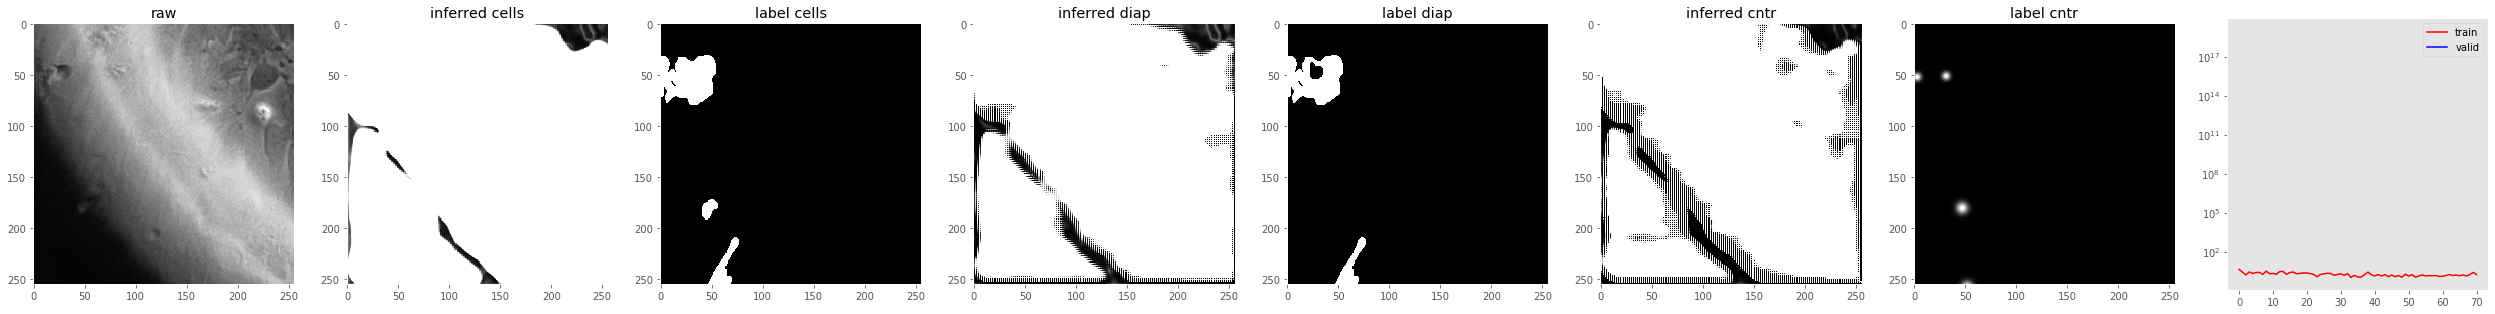

time per it: 3.067517


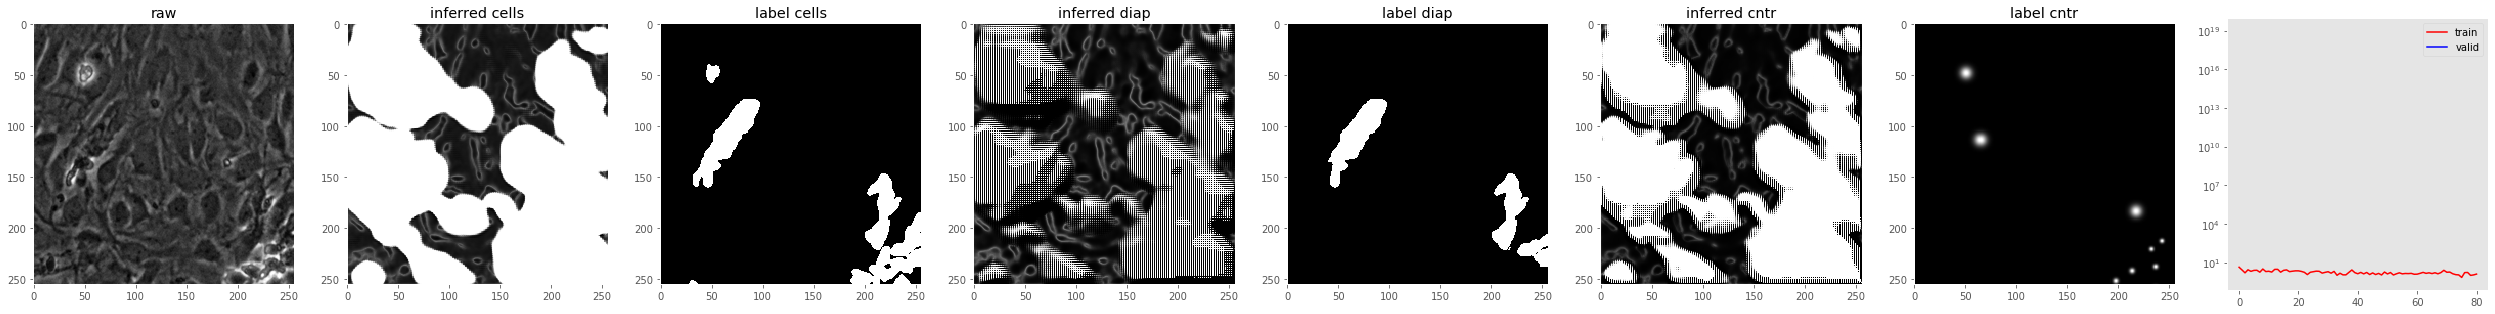

time per it: 3.070291


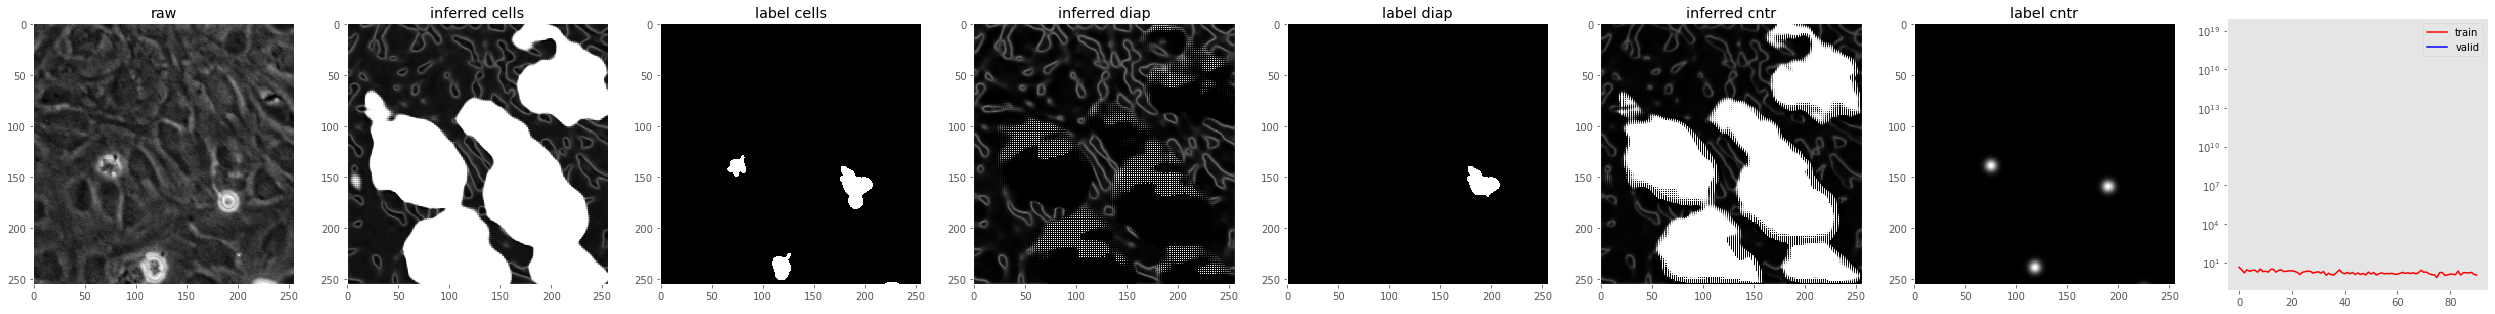

time per it: 3.133752
feed dict for validation


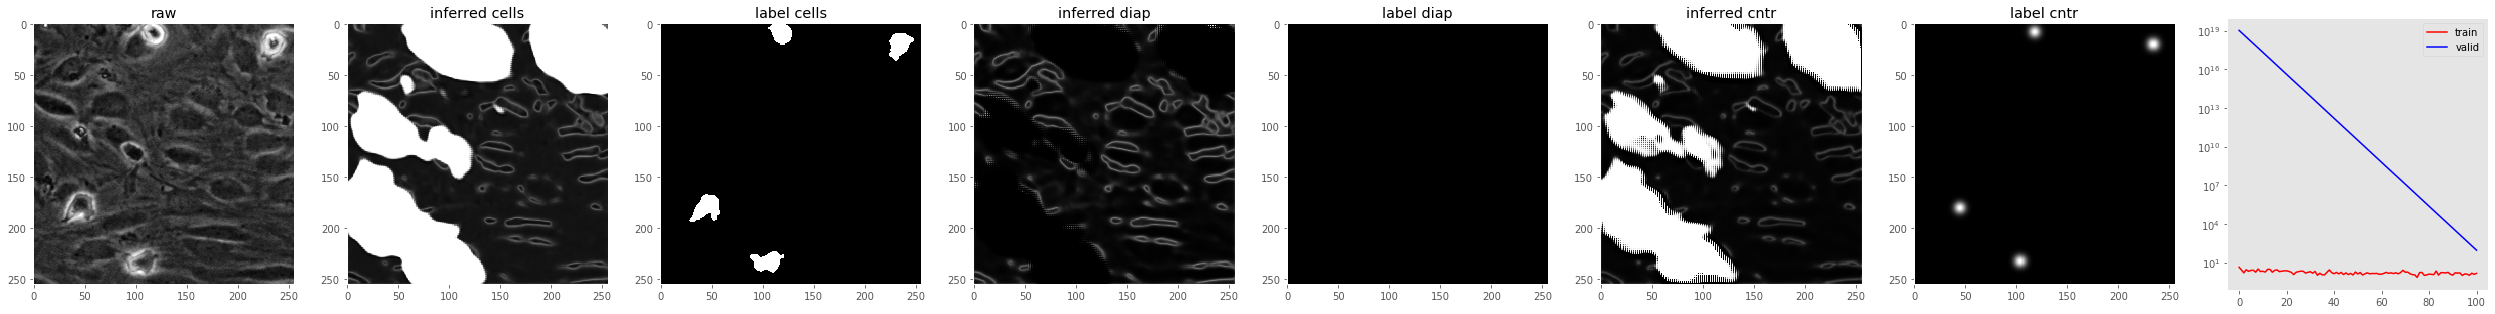

Setting lr=0.000750
time per it: 3.622388
feed dict for validation


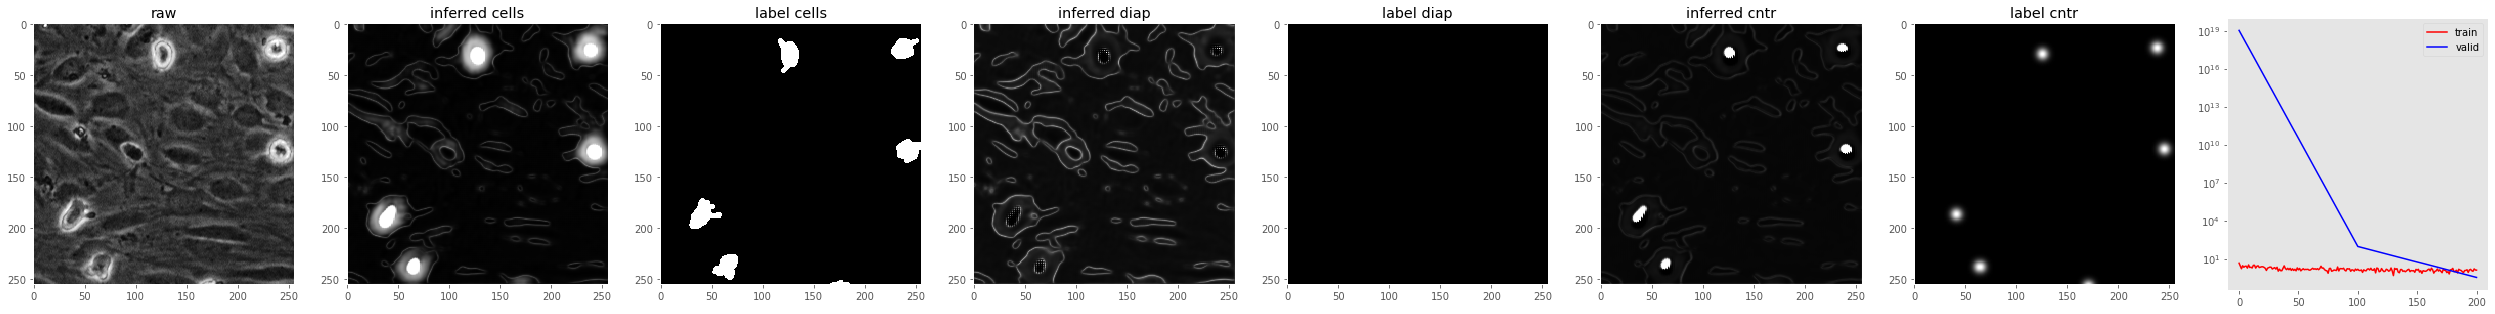

time per it: 3.616576
feed dict for validation


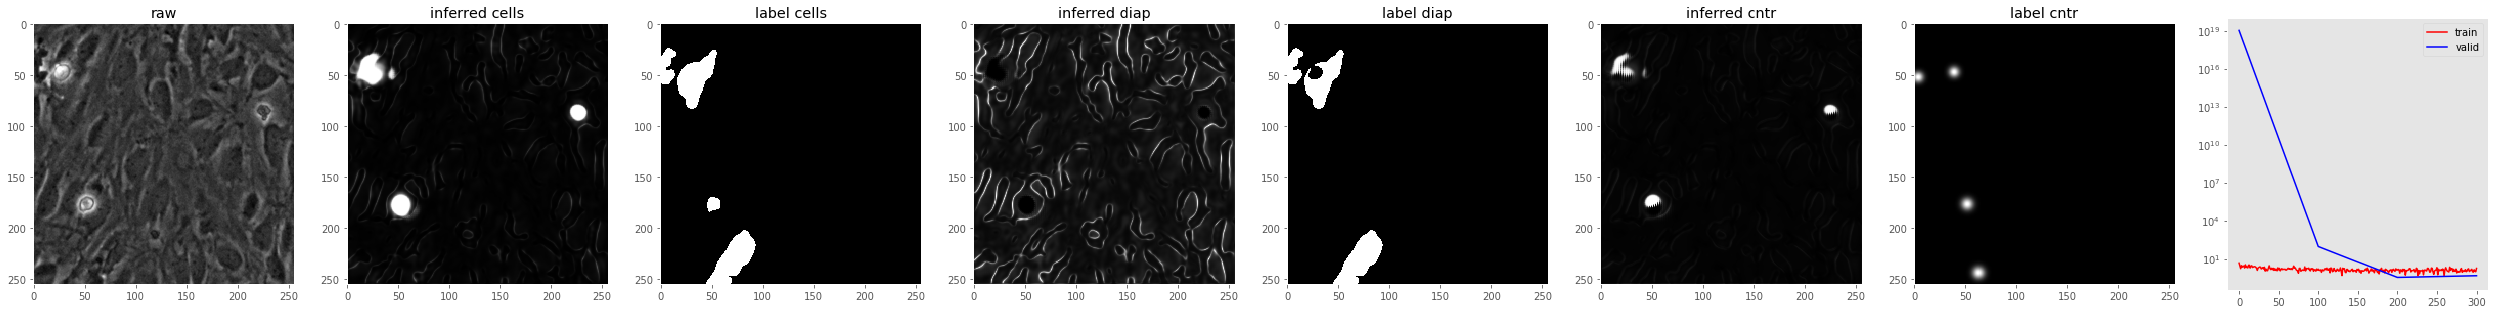

time per it: 3.655570
feed dict for validation


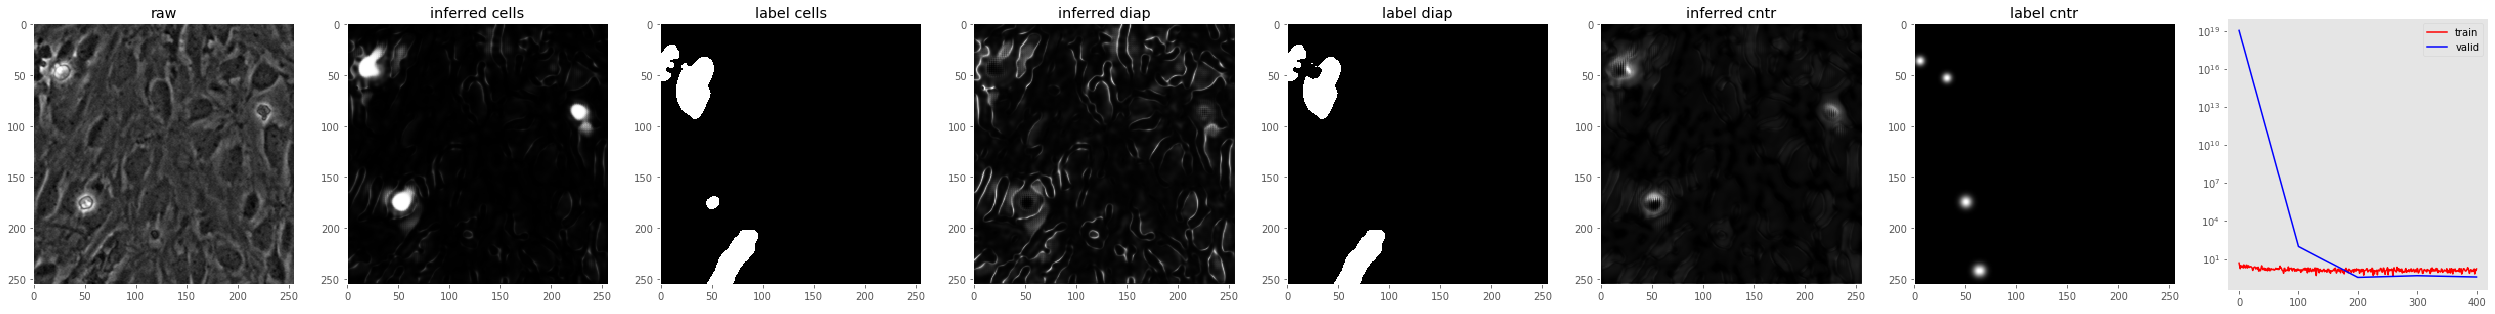

time per it: 3.669941
feed dict for validation


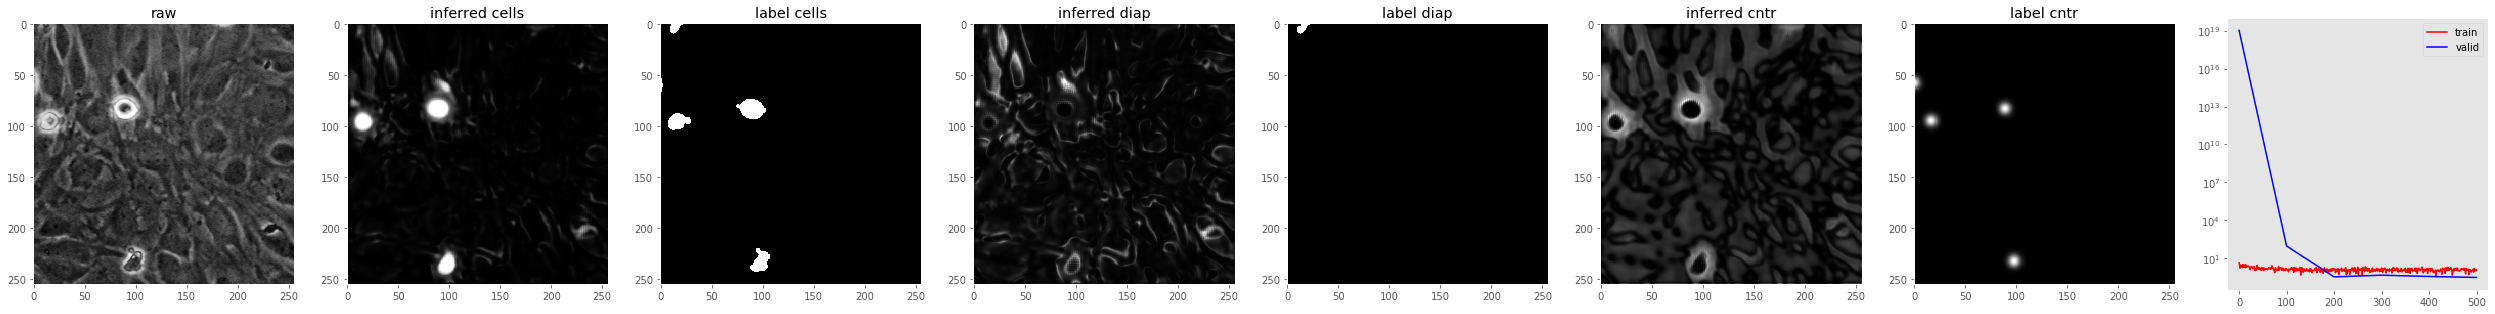

time per it: 3.045808
feed dict for validation


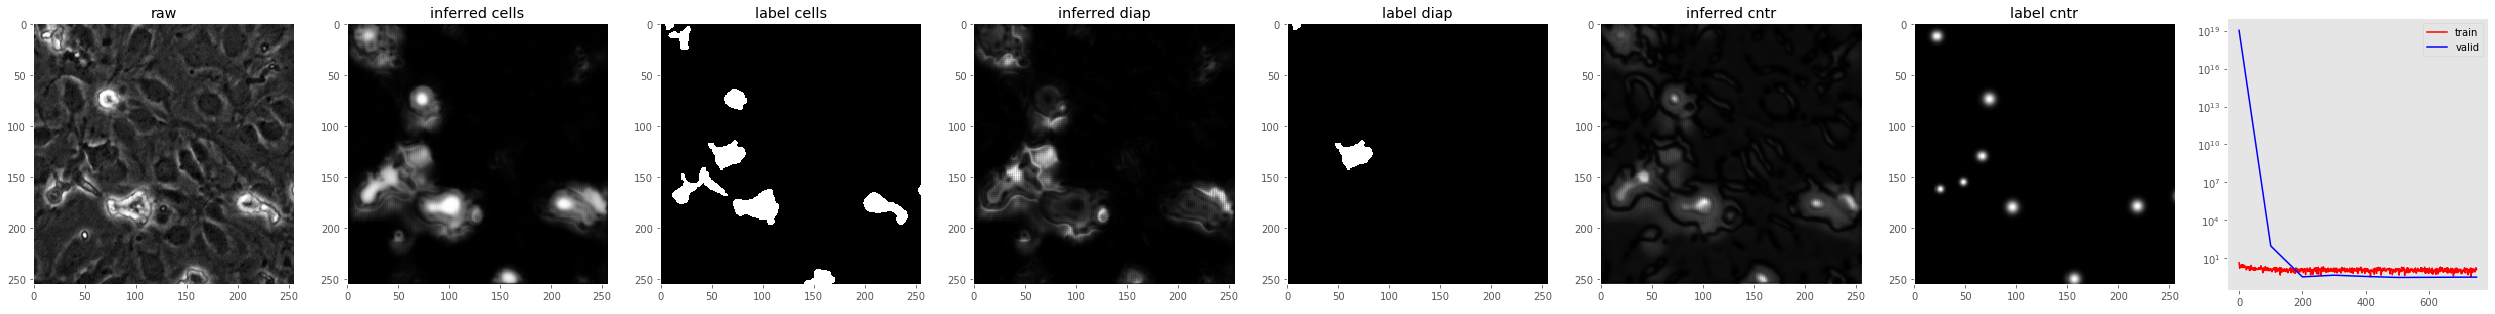

Setting lr=0.001500
time per it: 3.044355
feed dict for validation


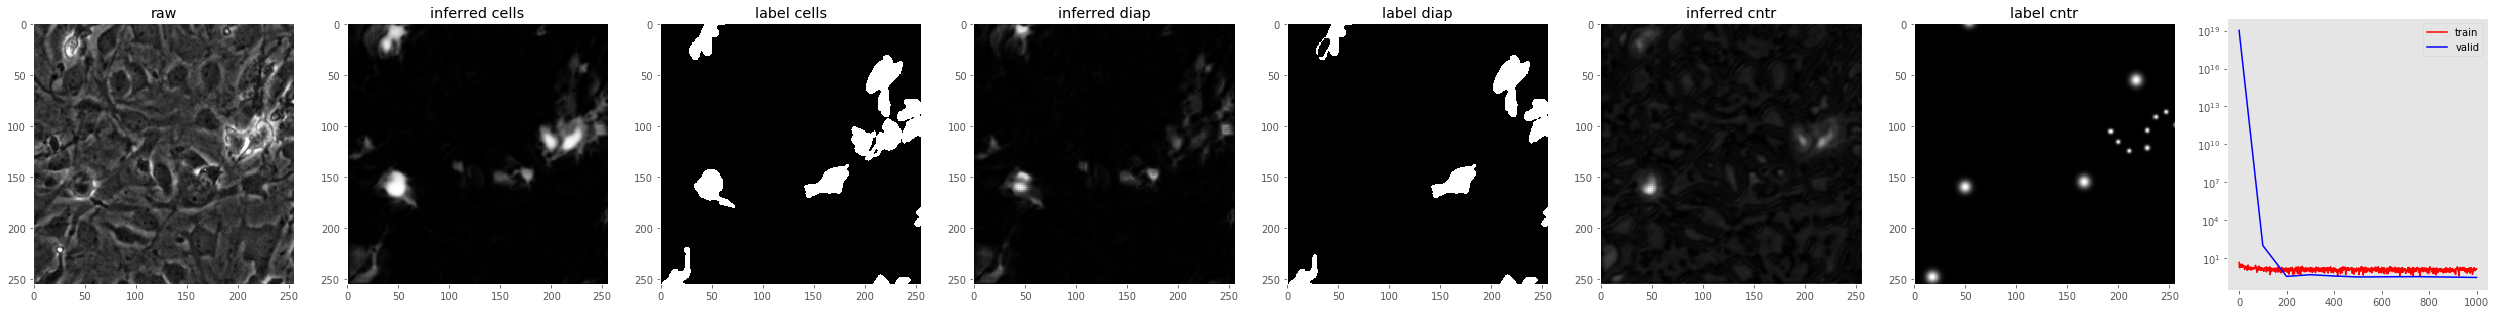

time per it: 3.059821
feed dict for validation


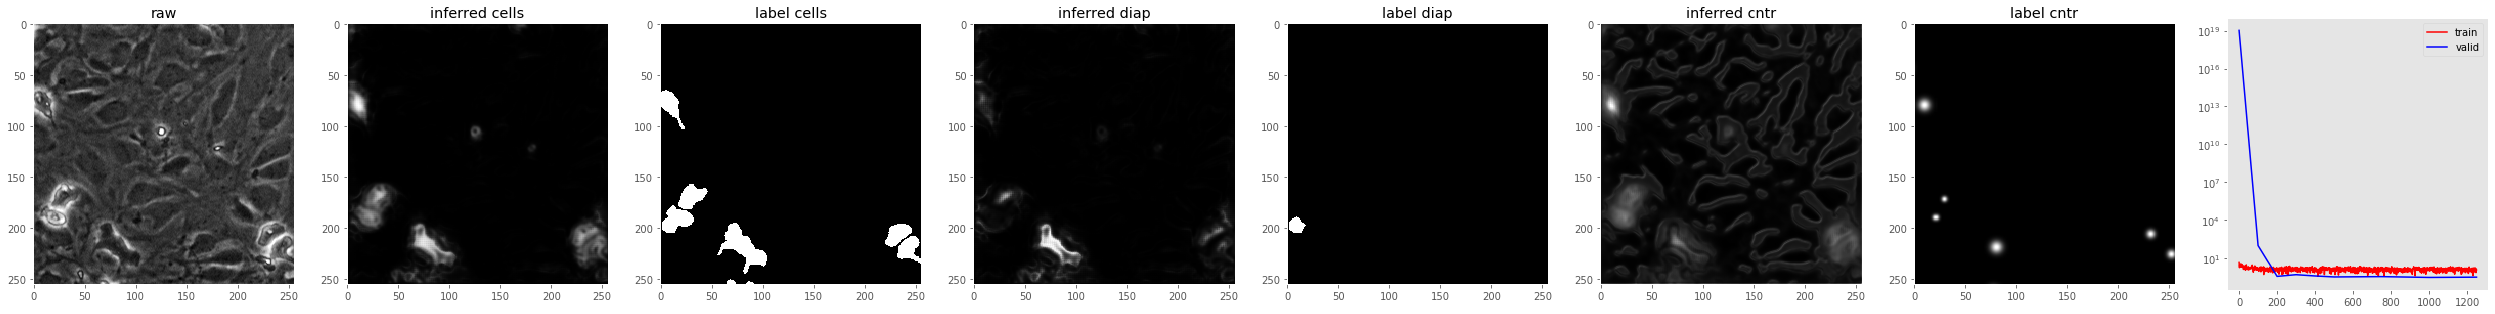

time per it: 3.110524
feed dict for validation


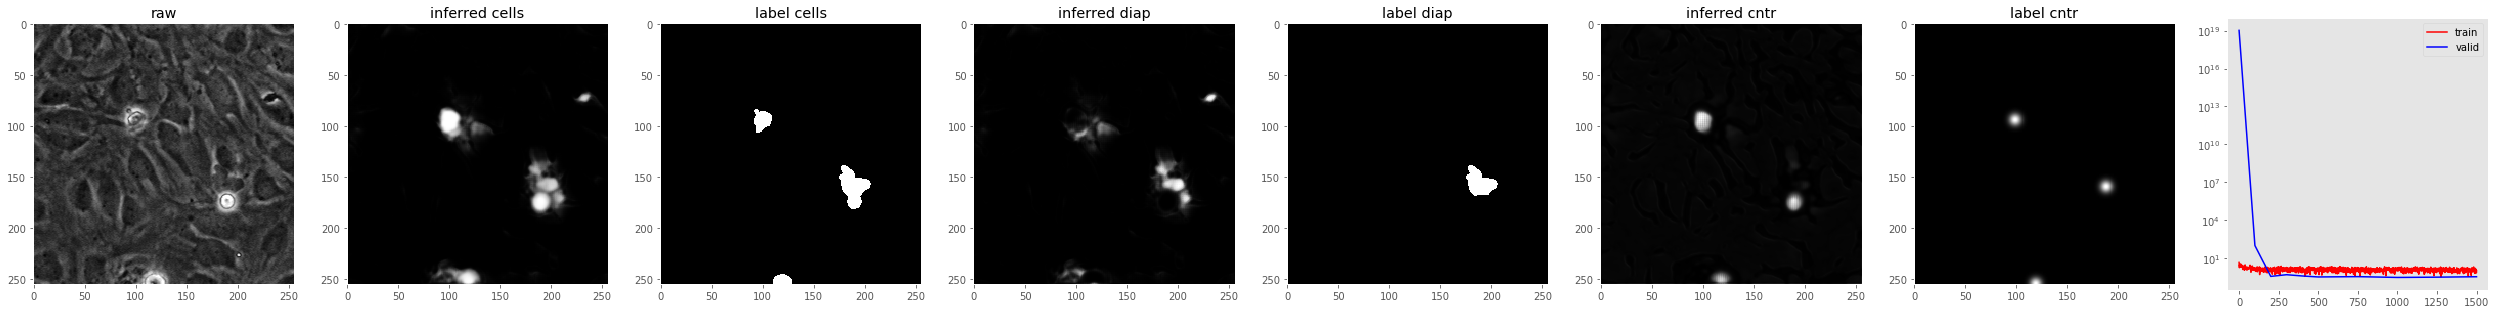

time per it: 3.066179
feed dict for validation


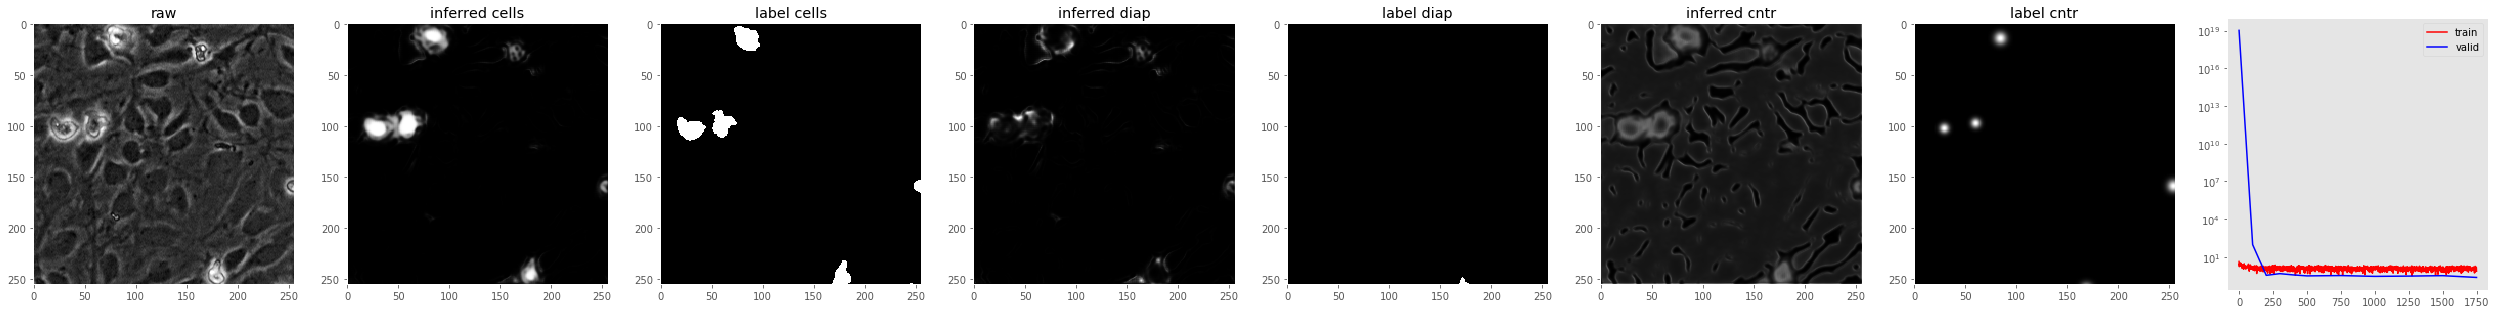

time per it: 3.074215
feed dict for validation


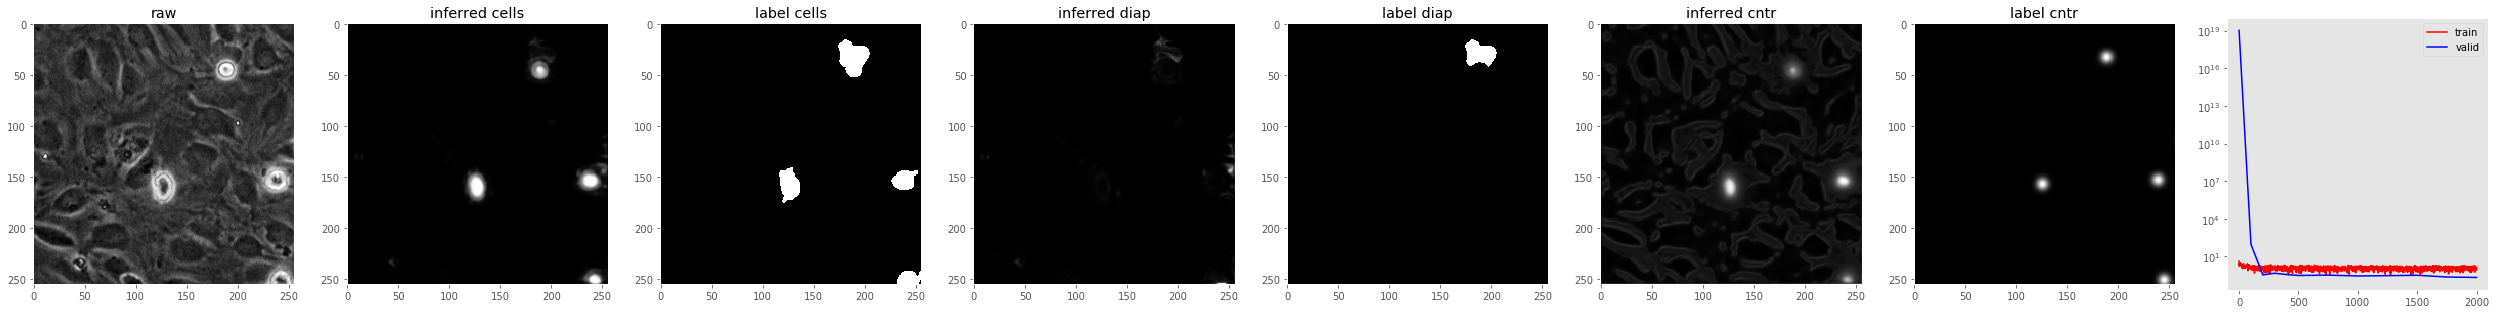

time per it: 2.726625
feed dict for validation


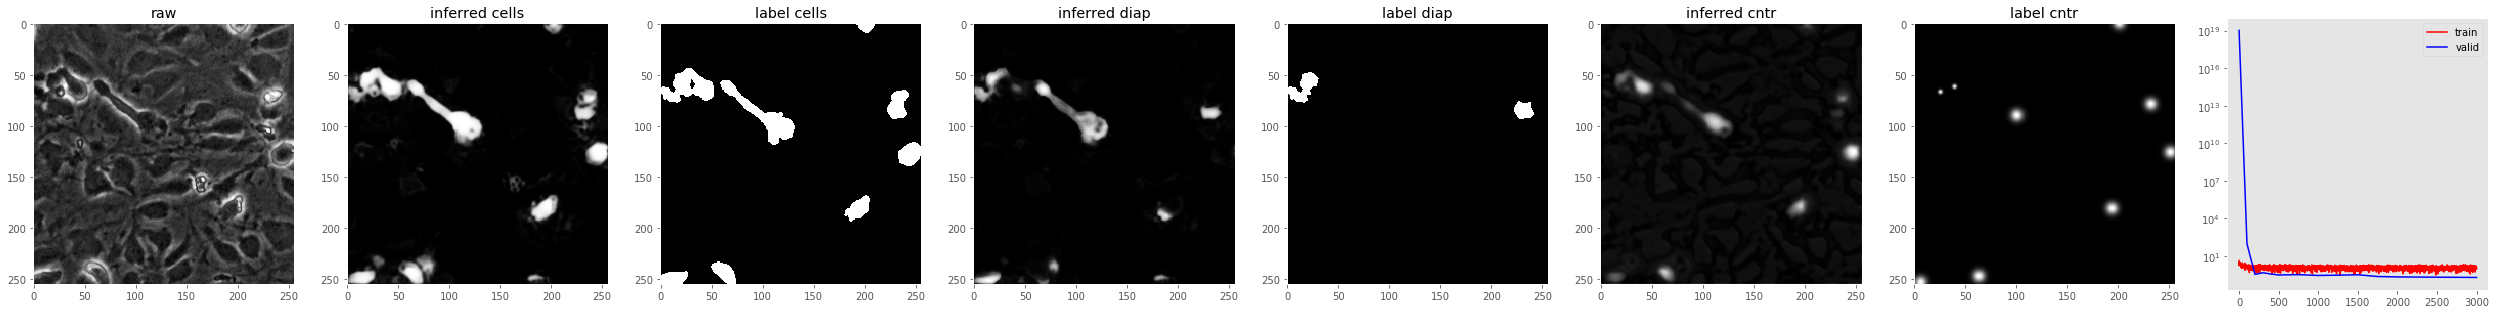

time per it: 2.729073
feed dict for validation


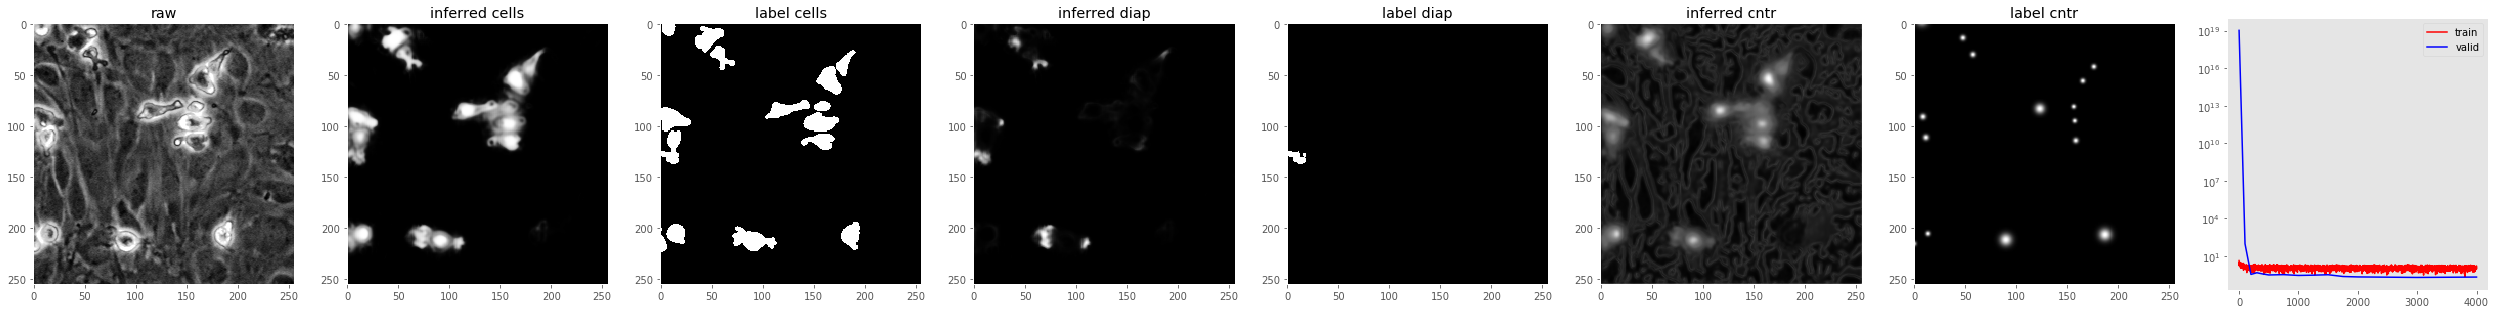

time per it: 2.740812
feed dict for validation


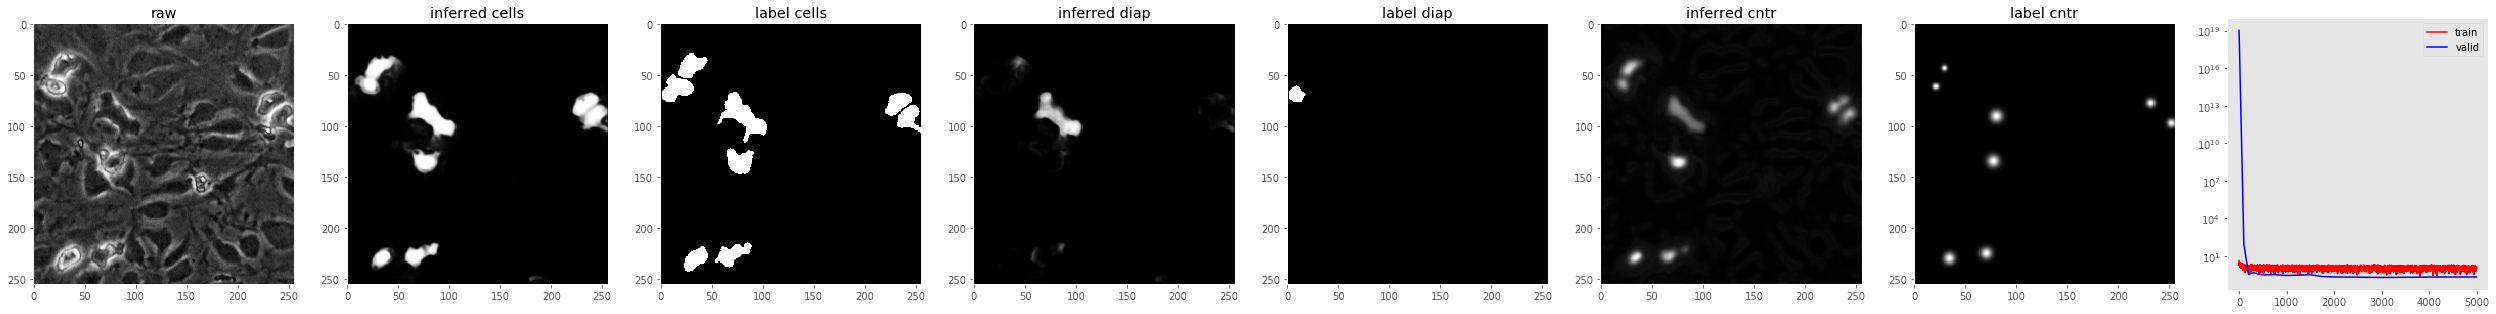

time per it: 2.660974
feed dict for validation


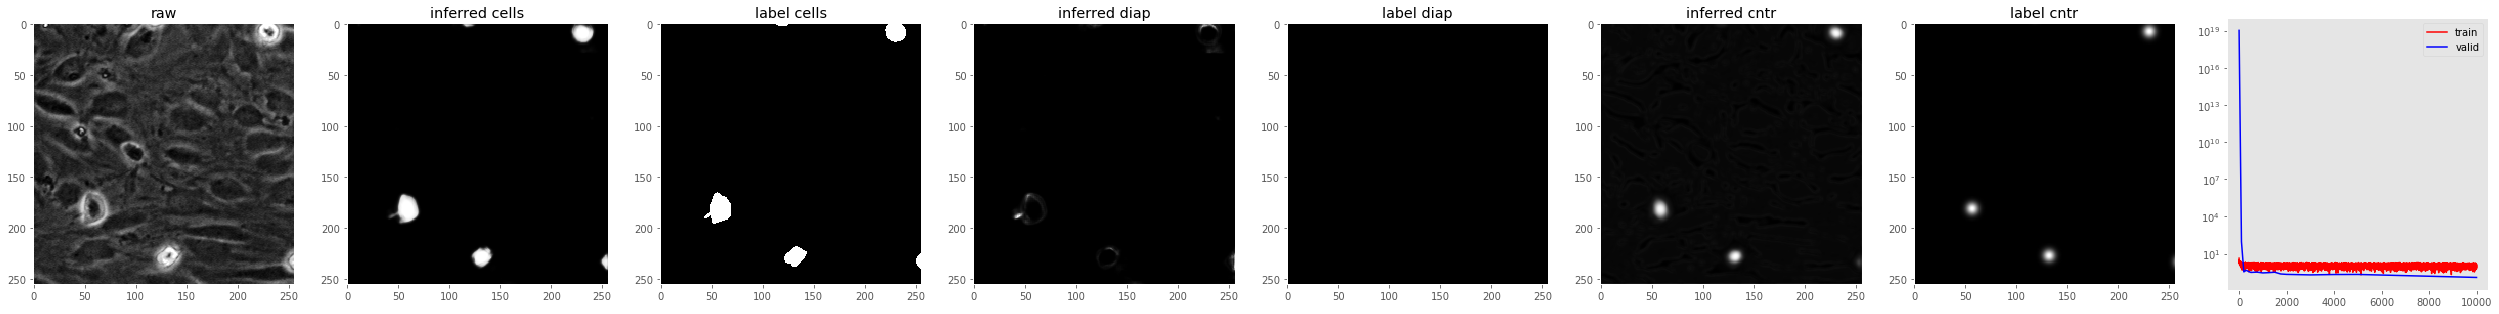

time per it: 2.658843
feed dict for validation


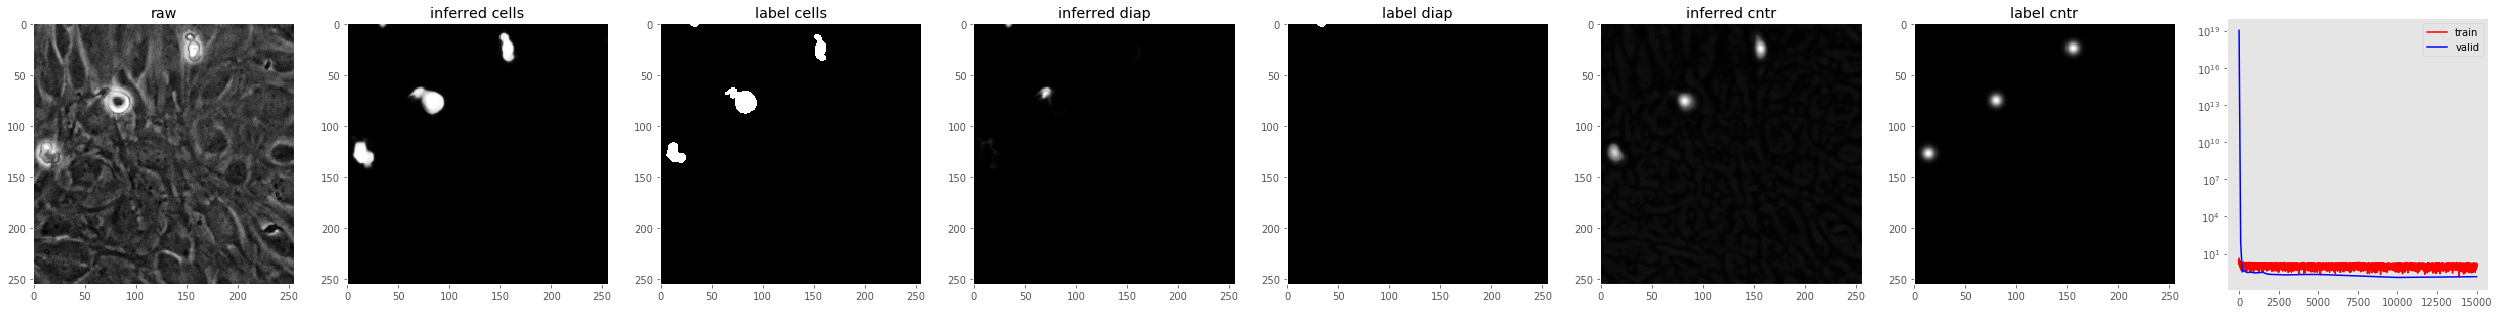

Setting lr=0.000750
time per it: 2.660243
feed dict for validation


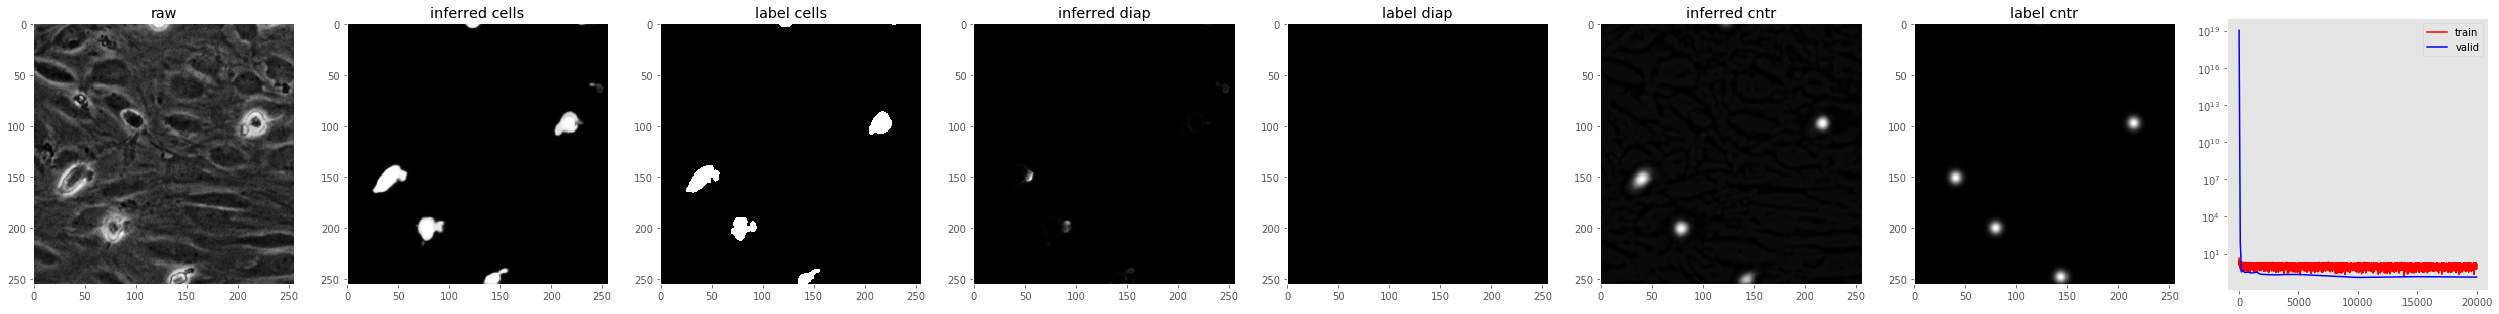

time per it: 2.629136
feed dict for validation


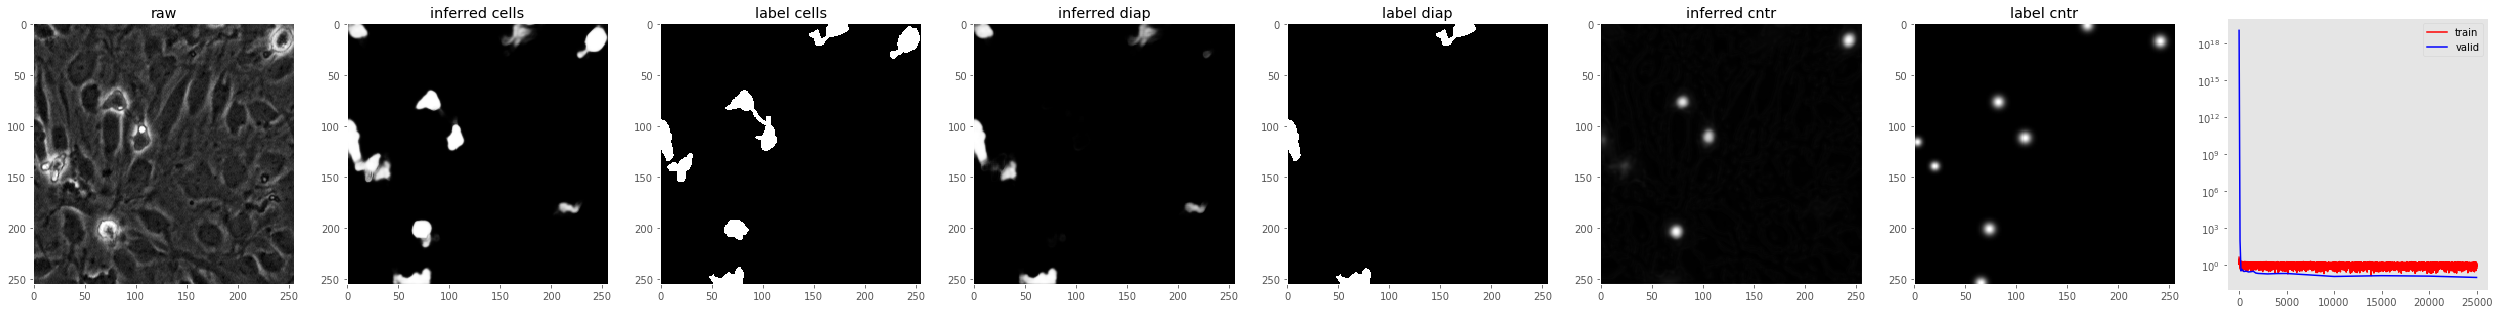

time per it: 2.529056
feed dict for validation


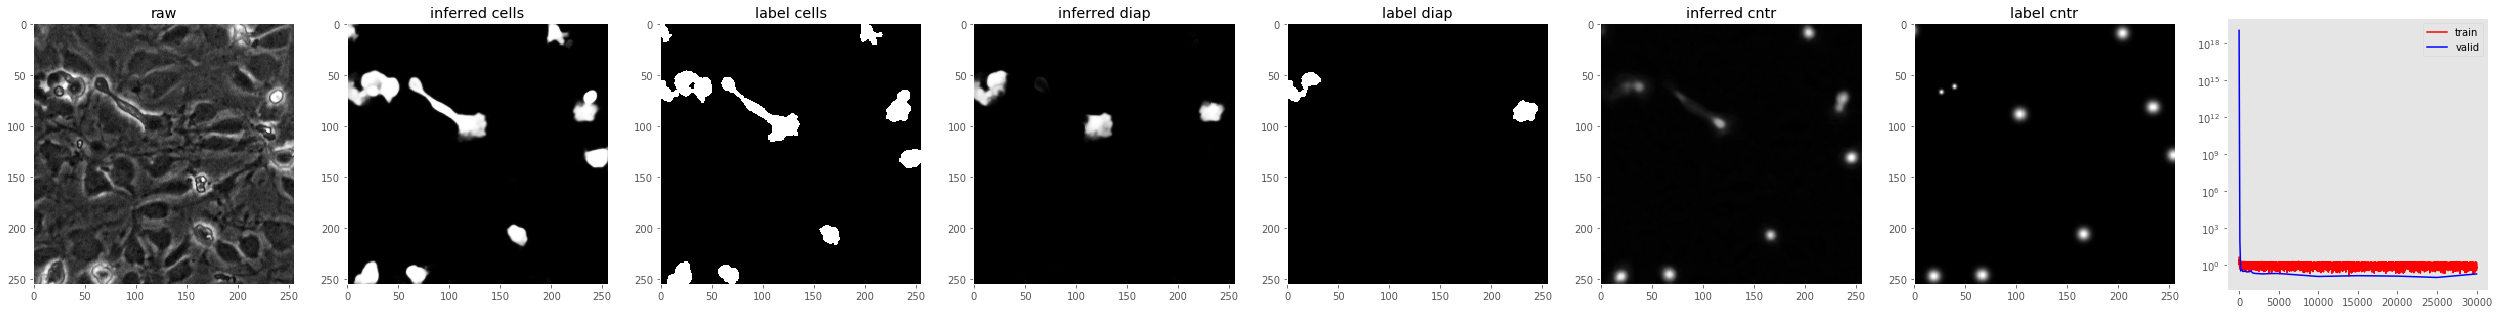

time per it: 2.526704
feed dict for validation


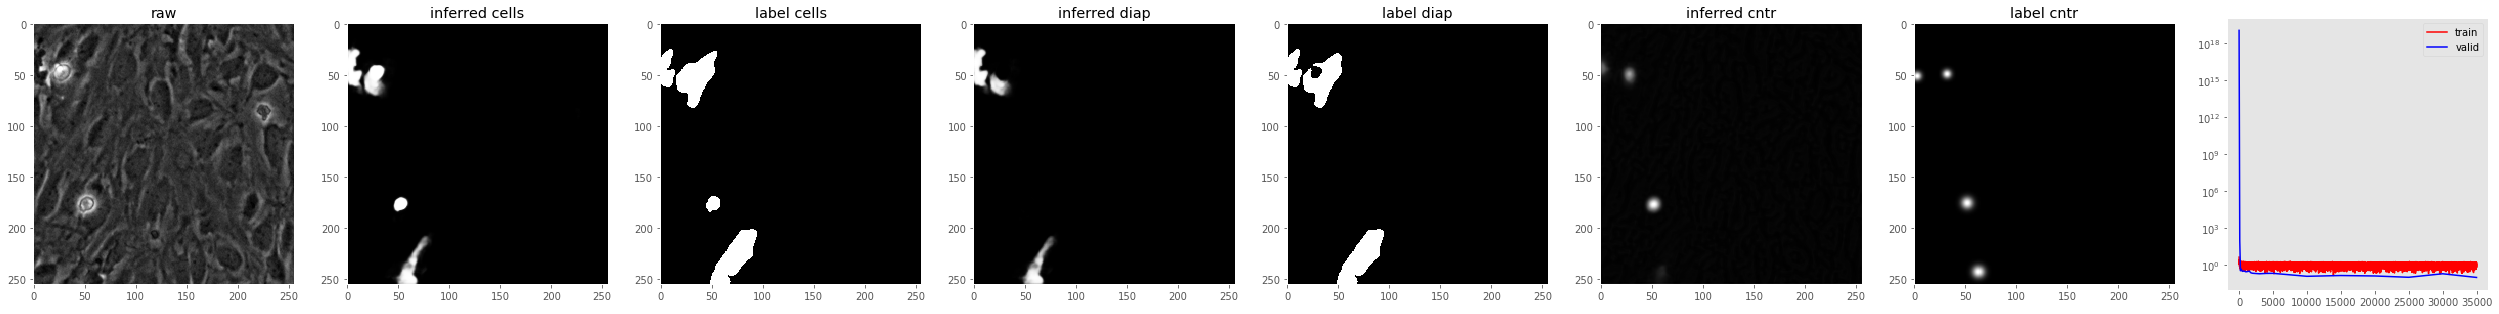

time per it: 2.531344
feed dict for validation


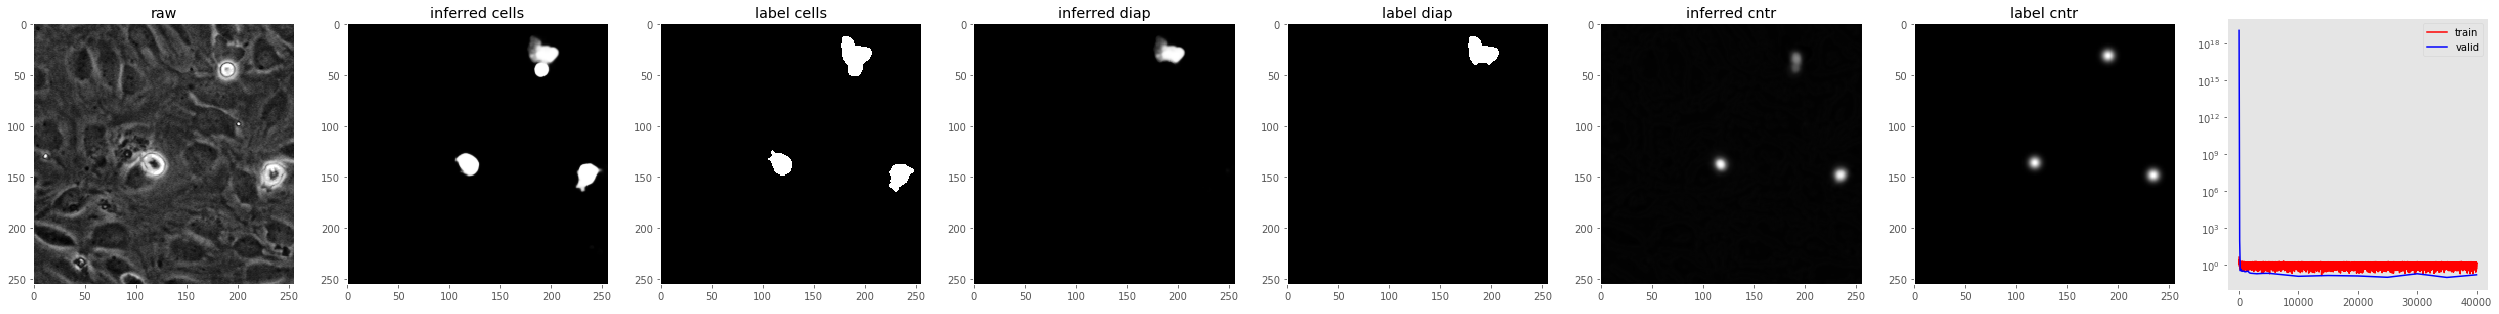

In [11]:
n_it = 40000
t_str = t.train(n_iter=n_it, learning_rate=0.0005*3,
        learning_rate_factors={0:0.25, 200:0.5, 1000:1, 20000:0.5, 40000:0.25, 90000:0.125})

In [12]:
#t.plot_validation(t_str, n_it)

In [13]:
with g.as_default():
    with tf.device('/gpu:0'):
        brd_ofs = 32
        
        map_cell_p = output[...,brd_ofs:-brd_ofs, brd_ofs:-brd_ofs, 0]>0.5
        map_cell_l = label[..., brd_ofs:-brd_ofs, brd_ofs:-brd_ofs]>0
        
        map_diap_p = output[..., brd_ofs:-brd_ofs, brd_ofs:-brd_ofs, 1]>0.5
        map_diap_l = diapd[..., brd_ofs:-brd_ofs, brd_ofs:-brd_ofs]>0

        i = tf.logical_and(map_cell_p, map_cell_l)
        u = tf.logical_or(map_cell_p, map_cell_l)
        
        i_s = tf.reduce_sum(tf.cast(i, tf.float32))
        u_s = tf.reduce_sum(tf.cast(u, tf.float32))
        
        iou_cell = i_s / u_s
        
        i = tf.logical_and(map_diap_p, map_diap_l)
        u = tf.logical_or(map_diap_p, map_diap_l)
        
        i_s = tf.reduce_sum(tf.cast(i, tf.float32))
        u_s = tf.reduce_sum(tf.cast(u, tf.float32))
        
        iou_diap = i_s / u_s
        
        iou = tf.stack([iou_cell, iou_diap], axis=0)

In [14]:
# eval IoU
iou_map = t.get_IoU_validation(t_str, n_it, [iou])

INFO:tensorflow:Restoring parameters from BBB/model_BBB_BN_TV_FCNx16_HN_CDC_2021.07.06_16-25/model-1
INFO:tensorflow:Restoring parameters from BBB/model_BBB_BN_TV_FCNx16_HN_CDC_2021.07.06_16-25/model-11
INFO:tensorflow:Restoring parameters from BBB/model_BBB_BN_TV_FCNx16_HN_CDC_2021.07.06_16-25/model-21
INFO:tensorflow:Restoring parameters from BBB/model_BBB_BN_TV_FCNx16_HN_CDC_2021.07.06_16-25/model-31
INFO:tensorflow:Restoring parameters from BBB/model_BBB_BN_TV_FCNx16_HN_CDC_2021.07.06_16-25/model-41
INFO:tensorflow:Restoring parameters from BBB/model_BBB_BN_TV_FCNx16_HN_CDC_2021.07.06_16-25/model-51
INFO:tensorflow:Restoring parameters from BBB/model_BBB_BN_TV_FCNx16_HN_CDC_2021.07.06_16-25/model-61
INFO:tensorflow:Restoring parameters from BBB/model_BBB_BN_TV_FCNx16_HN_CDC_2021.07.06_16-25/model-71
INFO:tensorflow:Restoring parameters from BBB/model_BBB_BN_TV_FCNx16_HN_CDC_2021.07.06_16-25/model-81
INFO:tensorflow:Restoring parameters from BBB/model_BBB_BN_TV_FCNx16_HN_CDC_2021.07

25000 0.7582299 0.44257513


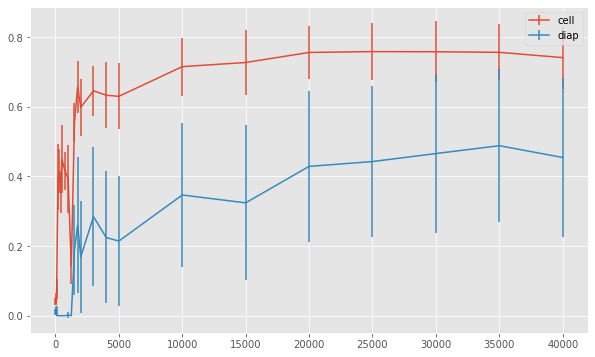

In [20]:
# plot ~ IoU
times = []
c_iou = []
d_iou = []
cs_iou = []
ds_iou = []

for key, val in iou_map.items():
    a = np.stack(val).squeeze()
    c_ious = a[:,0]
    d_ious = a[:,1]
    
    c_ious = c_ious[~np.isnan(c_ious)]
    d_ious = d_ious[~np.isnan(d_ious)]
    
    c_iou.append(c_ious.mean())
    d_iou.append(d_ious.mean())
    cs_iou.append(c_ious.std())
    ds_iou.append(d_ious.std())
    times.append(key)
    
c_iou = np.array( c_iou)
d_iou = np.array( d_iou)
cs_iou = np.array(cs_iou)
ds_iou = np.array(ds_iou)

plt.figure(figsize=(10, 6))
plt.errorbar(times, c_iou, yerr=cs_iou, label='cell')
plt.errorbar(times, d_iou, yerr=ds_iou, label='diap')
plt.legend()
idx = np.argmax(c_iou)
print(times[idx], c_iou[idx], d_iou[idx])

In [16]:
import pickle
dict_hist = {'tr': t.tra_loss_hist, 'val': t.val_loss_hist, 'valt': t.val_hist_time}
pckl_path = t.models_save_dir+'/model_'+t.model_name+'_'+t_str+'/'
pckl_name = pckl_path+'loss_hist.pckl'
with open(pckl_name, 'wb') as handle:
    pickle.dump(dict_hist, handle, protocol=pickle.HIGHEST_PROTOCOL)

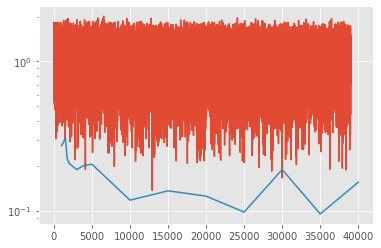

In [17]:
t0 = 1000
plt.semilogy(dict_hist['tr'][0][t0:])
vt = np.array(dict_hist['valt'])
vh = np.array(dict_hist['val'][0])

idx_in_t = vt>=t0
plt.semilogy(vt[idx_in_t], vh[idx_in_t])

INFO:tensorflow:Restoring parameters from BBB/model_BBB_BN_TV_FCNx16_HN_CDC_2021.07.06_16-25/model-10001
INFO:tensorflow:Restoring parameters from BBB/model_BBB_BN_TV_FCNx16_HN_CDC_2021.07.06_16-25/model-20001
INFO:tensorflow:Restoring parameters from BBB/model_BBB_BN_TV_FCNx16_HN_CDC_2021.07.06_16-25/model-30001
INFO:tensorflow:Restoring parameters from BBB/model_BBB_BN_TV_FCNx16_HN_CDC_2021.07.06_16-25/model-40000


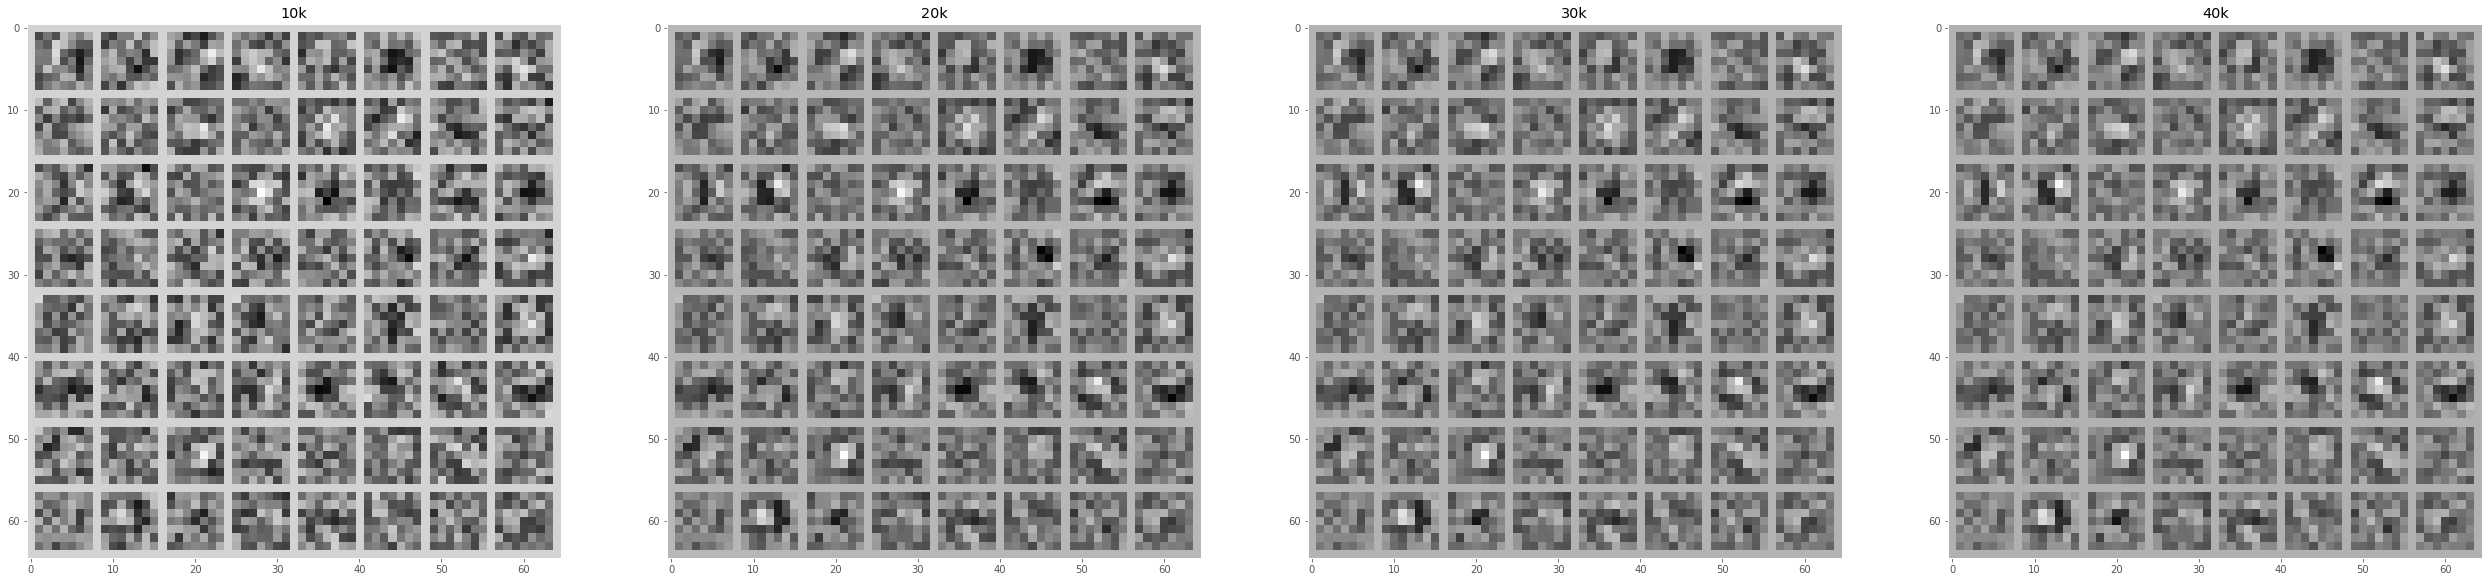

(None, <Figure size 3168x720 with 4 Axes>)

In [18]:
draw_idxs = [10001, 20001, 30001, 40000]

w0 = g.get_tensor_by_name('L0/W:0')

flts = []
lbls = []

for d_idx in draw_idxs:
    sess = t.get_session(start_params_dict={'time':t_str, 'idx':d_idx})
    w0r = sess.run(w0)
    flts.append(w0r.transpose(0, 3, 4, 1, 2).reshape(-1, 7, 7))
    sess.close()
    
    lbls.append(f'{d_idx//1000}k')

ims = [iio.montage(f) for f in flts]
iio.draw_samples(ims, lbls)


In [22]:
time.sleep((devs[0]%4)*60*60) # 1h delay between each

# Save validation predition for performance evaluation

In [23]:
%%time
mb_sz = 4

out_d = {'in':v.inputs_tiles[0][:, 2],
         'gt':np.stack([v.outputs_tiles[0][:, 2],
                        v.outputs_tiles[1][:, 2],
                        v.outputs_tiles[2][:, 2]
                       ], axis=-1),
         'pred':{}
        }
pred = out_d['pred']
save_times = [10000, 15000, 20000, 25000, 30000, 35000, 39999]

for t_idx in save_times:
    tm = t_idx + 1
    sess = t.get_session(start_params_dict={'time':t_str, 'idx':tm})
    n_tiles = len(v.inputs_tiles[0])
    n_it = n_tiles//mb_sz
    
    all_out = []
    for i in range(n_it):
        i_b = i*mb_sz
        i_e = i_b+mb_sz
        
        it = v.inputs_tiles[0][i_b:i_e]
        #stk0, lbl0, dia0, cnt0, dst0
        out = sess.run(output, feed_dict={stk0:it, phase_train:False})
        all_out.append(out)
    sess.close()

    all_out = np.concatenate(all_out, axis=0)[:,0]
    pred[tm] = all_out

valid_summary_name = os.path.dirname(t.get_checkpoint_file(start_params_dict={'time':t_str, 'idx':0}) )
valid_summary_name = os.path.join(valid_summary_name, 'valid_summ.pckl')

import pickle

with open(valid_summary_name, 'wb') as handle:
    pickle.dump(out_d, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
del out_d

INFO:tensorflow:Restoring parameters from BBB/model_BBB_BN_TV_FCNx16_HN_CDC_2021.07.06_16-25/model-10001
INFO:tensorflow:Restoring parameters from BBB/model_BBB_BN_TV_FCNx16_HN_CDC_2021.07.06_16-25/model-15001
INFO:tensorflow:Restoring parameters from BBB/model_BBB_BN_TV_FCNx16_HN_CDC_2021.07.06_16-25/model-20001
INFO:tensorflow:Restoring parameters from BBB/model_BBB_BN_TV_FCNx16_HN_CDC_2021.07.06_16-25/model-25001
INFO:tensorflow:Restoring parameters from BBB/model_BBB_BN_TV_FCNx16_HN_CDC_2021.07.06_16-25/model-30001
INFO:tensorflow:Restoring parameters from BBB/model_BBB_BN_TV_FCNx16_HN_CDC_2021.07.06_16-25/model-35001
INFO:tensorflow:Restoring parameters from BBB/model_BBB_BN_TV_FCNx16_HN_CDC_2021.07.06_16-25/model-40000
CPU times: user 9min 20s, sys: 2min 44s, total: 12min 5s
Wall time: 10min 59s
